*Avtor:* Tim Kmecl

In [1]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.optimize
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set("paper")
sns.set()
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"axes.facecolor": ".995",
                            'axes.spines.left': False,
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'axes.edgecolor': '.5',
                            'axes.grid': True,
                            'grid.color': '.85'})

plt.rcParams["figure.figsize"] = [6.4, 4.8]

plt.rcParams["lines.linewidth"] = 2

plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.markeredgecolor"] = "w"
plt.rcParams["lines.markeredgewidth"] = "2"
plt.rcParams["lines.markersize"] = 6
palette = "Blues_d"

plt.rcParams['figure.dpi'] = 100

blues_d = cm.Blues(np.linspace(.3, 1, 5))
blues_dd = cm.Blues(np.linspace(.3, 1, 5))

cmap = np.concatenate((cm.Blues(np.linspace(0.3, 1, 5))[:,:3], 0.3 +  cm.plasma(np.linspace(0.15, 1, 7))[:,:3]*0.7))
cm_stran = cmap[[4, 2, 0, 5,6,7,8,9,10,11, 1, 3]]
cmap = cmap[[4, 3, 2, 1, 0, 5,6,7,8,9,10,11]]

save_dpi=150
cur_img = 0

In [4]:
def utils_plot1(ax, log, title, ylim, xticks):
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.set_title(title + (" [log]" if log else ""))
    ax.set_ylim(0 if (ylim==None and not log) else (0.95 if ylim==None else ylim))
    ax.set_yscale("log" if log else "linear")
    ax.xaxis.set_tick_params(labelbottom=True)
    plt.subplots_adjust(wspace=0.13, top=0.91, left=.06, right=.93, bottom=.08) 
    ax.set(xlabel=None)
    if log:
        ax.grid(axis="y", which="both")
    
def plot_bar_m1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, width=(0.6, 0.5, 0.1), show=True, x3=None, y3=None):
    if not x2 is None and not y2 is None:
        ax.bar(x2, y2, color="lightblue", width=(width[1] if len(width)>1 else width[0]))
    if len(x) and len(y):
        ax.bar(x, y, color="b", width=width[0])
    if x3 is not None and y3 is not None:
        ax.bar(x3, y3, width=(width[2] if len(width)>2 else width[0]), color=".25", alpha=.7, linewidth=0)
    
    utils_plot1(ax, log, title, ylim, xticks)

def plot_line1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None, m2=True, show=True, color=None):
    if x2 is not None and y2 is not None:
        sns.lineplot(x2, y2, color=("lightblue" if m2 else "orange"), marker=(plt.rcParams["lines.marker"] if m2 else ""), ax=ax)
    if len(x) and len(y):
        sns.lineplot(x, y, color=("b" if not color else color), ax=ax)
    
    utils_plot1(ax, log, title, ylim, xticks)

def plot_bar1(ax, x, y, log=False, title=None, ylim=None, xticks=None, x2=None, y2=None):
    if not x2 is None and not y2 is None:
        sns.lineplot(x2, y2, color="orange", marker="", ax=ax)
    if len(x) and len(y):
        ax.bar(x, y, color="b", width=0.7)
    
    utils_plot1(ax, log, title, ylim, xticks)

In [206]:
def cat(l):
    return np.concatenate(l)

def reverse_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

---

%%latex
\newpage

# Podatki

Vir 1: NIJZ *\[[Spremljanje koronavirusa SARS-CoV-2 (COVID-19)](https://www.nijz.si/sl/pojav-novega-koronavirusa-2019-ncov)\]*  
Vir 2: prirejeno po NIJZ: *\[[Dnevno spremljanje okužb s SARS-CoV-2 (COVID-19) [graf]](https://www.nijz.si/sl/dnevno-spremljanje-okuzb-s-sars-cov-2-covid-19)\]*  
Vir 3: Objave vlade na [gov.si](https://www.gov.si/teme/koronavirus/) in [twitterju](https://twitter.com/vladaRS).  
*Vir 4: Luka Renko et al., [COVID-19 Slovenija](https://slo-covid-19.rtfm.si/#/about)*

Na grafih je *vir 2* temno moder, *vir 1* svetlo moder, *vir 3* pa siv.

- pri *vir 1* so podatki na začetku za ob 14h, od dneva 11 naprej ob ~10-14h na določen dan, zato so na grafu zamaknjeni za 0.5 dneva v levo  
- pri *vir 2* so podatki na začetku za konec dneva, od dneva 15 naprej naslednji dan ob 10h  
- pri *vir 3* ni točno zabeleženo, na katero obdobje se podatki nanašajo, objavljeno enkrat popoldne  
- *vir 4* samo za hospitalizacije ipd. (neuradno!), in po regijah ter starostirh (uradno, posredno iz *vir 2*)  

Dan 1 je *4.3.*, zadnjič posodobljeno *24.3.* (zadnji celodnevni podatek velja za en dan nazaj).

### Podatki o okuženih

In [6]:
podatki_okuzeni = [
 [1, 1, 1],
 [2, 4, 6],
 [3, 8, 9],
 [4, 12, 13],
 [5, 16, 19],
 [6, 23, 29],
 [7, 31, 47],
 [8, 57, 77],
 [9, 89, 127],
 [10, 141, 174],
 [11, 181, 215],
 [12, 219, 247],
 [13, 253, 272],
 [14, 275, 283],
 [15, 286, 315, 317],
 [16, 319, 339, 341],
 [17, 341, 368, 379],
 [18, 383, 402, 412], # ali s=385 (tw, 17h)
 [19, 414, 439, 440],
 [20, 442, 478],
 [21, 480, -1]]

#vir1 - Na začetku ob 14h, od dneva 11 naprej ob ~10h
dniS = np.array([d[0] for d in podatki_okuzeni])
dniS1 = np.array([d[0] for d in podatki_okuzeni if d[0] < 21])
okuzeniS = np.array([d[1] for d in podatki_okuzeni])
okuzeniS1 = np.array([d[1] for d in podatki_okuzeni if d[0] < 21])

#vir2 - Konec dneva, od dneva 15 naprej naslednji dan ob 10h
dni = np.array([d[0] for d in podatki_okuzeni[:-1]])
okuzeni = np.array([d[2] for d in podatki_okuzeni[:-1]])

In [7]:
novi = np.array([okuzeni[0]] + [okuzeni[i+1] - okuzeni[i] for i in range(okuzeni.shape[0] - 1)])
noviS = np.array([okuzeniS[0]] + [okuzeniS[i+1] - okuzeniS[i] for i in range(okuzeniS.shape[0] - 1)])
noviS1 = np.array([okuzeniS1[0]] + [okuzeniS1[i+1] - okuzeniS1[i] for i in range(okuzeniS1.shape[0] - 1)])

In [8]:
rast = np.array([okuzeni[i+1]/okuzeni[i] for i in range(okuzeni.shape[0] - 1)])
podvojitev = math.log(2)/np.log(rast)

rastS = np.array([okuzeniS[i+1]/okuzeniS[i] for i in range(okuzeniS.shape[0] - 1)])
podvojitevS = math.log(2)/np.log(rastS)


dbl_d2 = math.log(2)/math.log(np.average(rast[-2:]))
dbl_d1 = math.log(2)/math.log(rast[-1])

### Podatki o testih

In [9]:
diff = 313 # št. testiranih pred dnem 1
podatki_testirani = [
 [-3, 183, 183],
 [-2, 208, 208],
 [-1, 255, 255],
 [0, 290, 313],
 [1, 352, 364],
 [2, 433, 467],
 [3, 498, 745],
 [4, 785, 922],
 [5, 981, 1160],
 [6, 1227, 1527],
 [7, 1643, 2069],
 [8, 2270, 2818],
 [9, 3058, 3863],
 [10, 4346, 5060],
 [11, 5369, 5976],
 [12, 6156, 6566],
 [13, 6712, 7437],
 [14, 7587, 8558],
 [15, 8730, 9584],
 [16, 9860, 10768], #10732
 [17, 10980, 12010], #11940
 [18, 12250, 12882],
 [19, 13098, 13613],
 [20, 13812, 14870],
 [21, -1, -1]]

#Ker v tej tabeli desni stolpec pomeni okužbe ob koncu dneva in ne naslednji dan ob 10h kot za okužene
# za računanje razmerij med okuženimi in testi uporabljam namesto zadnje vrednosti v njem spodnjo
#drugacen_zadnji_testi = 12162
testirani_drug_z = np.array([d[2] for d in podatki_testirani[:-1]])

#vir1 - Na začetku ob 14h, od dneva 11 naprej enkrat med 10h in 14h. Nekateri dnevi manjkajo
dni_testS = np.array([d[0] for d in podatki_testirani if d[1]>0])
testiraniS = np.array([d[1] for d in podatki_testirani if d[1]>0])

#vir2 - Konec dneva, zadnji dan vključuje še teste naslednjega dne do enkrat med 10h in 14h
dni_test = np.array([d[0] for d in podatki_testirani[:-1]])
testirani = np.array([d[2] for d in podatki_testirani[:-1]])

#d = [[dni_testS[i], testiraniS[i]] for i in range(len(dni_testS))]

In [10]:
novi_testi = np.array([(testirani[i+1] - testirani[i])/(dni_test[i+1] - dni_test[i]) 
                       for i in range(dni_test.shape[0] - 1)])
novi_testi_drug_z = np.array([(testirani_drug_z[i+1] - testirani_drug_z[i])/(dni_test[i+1] - dni_test[i]) 
                       for i in range(dni_test.shape[0] - 1)])

novi_testiS = np.array([(testiraniS[i+1] - testiraniS[i])/(dni_testS[i+1] - dni_testS[i]) 
                       for i in range(dni_testS.shape[0] - 1)])

### Razmerja med testi in okuženimi

In [11]:
dni_odstotek = np.array([i for i in dni_test if i >= 0])

# Odstotek pozitivnih skupaj in za posamezen dan
odstotek_poz = np.insert(okuzeni/testirani[4:], 0, 0)
odstotek_poz_novi =  np.insert(novi/novi_testi_drug_z[3:], 0, 0)

# Testi na posameznega okuženega
testi_na_okuzenega =testirani_drug_z[4:]/okuzeni
novi_testi_na_okuzenega = novi_testi_drug_z[3:]/okuzeni
novi_testi_na_novega = novi_testi_drug_z[3:]/novi


dni_odstotekS = np.array([i for i in dni_testS if i >= 0 and i < 21])

odstotek_pozS = np.insert(okuzeniS1/testiraniS[4:], 0, 0)
odstotek_poz_noviS = np.insert(noviS1/novi_testiS[3:], 0, 0)

testi_na_okuzenegaS =testiraniS[4:]/okuzeniS1
novi_testi_na_okuzenegaS = novi_testiS[3:]/okuzeniS1
novi_testi_na_novegaS = novi_testiS[3:]/noviS1

#### Dodatne informacije *(vir 3)*

In [56]:
podatki_ekstra = [
    [9, 9, 5],  # za primerjavo v poznejših grafih
    [15, 36, 6], #20h, 8740testov, 286poz = 14h
    [16, 45, 6], #21h
    [17, 55, 9, 1046, 28], #17h +1046test +28poz
    [18, 56, 9, 1482, 44],  #14h 385poz (2+kot nijz)
    [19, 55, 10, 1088, 46], #14h
    [20, 64, 10, 714, 28], # 15h
    [21, 65, 10, 1058, 36]
]
skupaj_umrli = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3, 4] #zadnji d20

dni_ekstra = np.array([1] + [d[0] for d in podatki_ekstra])
hospitalizirani = np.array([0] + [d[1] for d in podatki_ekstra])
intenzivni = np.array([0] + [d[2] for d in podatki_ekstra])

skupaj_umrli_rel = skupaj_umrli/okuzeniS
hospitalizirani_rel = hospitalizirani[2:]/okuzeniS[14:]
intenzivni_rel = intenzivni[2:]/okuzeniS[14:]

dni_ekstra2 = np.array([d[0] for d in podatki_ekstra if len(d)>3])
novi_ekstra = np.array([d[4] for d in podatki_ekstra if len(d)>3])
novi_testi_ekstra = np.array([d[3] for d in podatki_ekstra if len(d)>3])

In [57]:
rast_ekstra = 1+ novi_ekstra/okuzeniS[dni_ekstra2-1-1]
podvojitev_ekstra = math.log(2)/np.log(rast_ekstra)

odstotek_poz_novi_ekstra = novi_ekstra/novi_testi_ekstra
novi_testi_na_novega_ekstra = novi_testi_ekstra/novi_ekstra

#### Hospitalizacije, regije in starost *(vir 4)*

In [61]:
d4 = pd.read_csv("./slo_covid.csv")
d4 = d4.set_index("day")

In [15]:
# Hospitalizacije
def get_col(key, d=d4):
    values = d[key][d[key].notna()].to_numpy()
    days = d[key][d[key].notna()].index.to_numpy()
    return (days, values)

hospit4 = get_col("state.in_hospital")
intenz4 = get_col("state.icu")
dni_hospit = cat(([1], hospit4[0]))
hospit4 = cat(([0], hospit4[1]))
intenz4 = cat(([0], intenz4[1]))

hospit4_rel = hospit4[1:]/okuzeniS[7:]
intenz4_rel = intenz4[1:]/okuzeniS[7:]

In [16]:
# Regije
regije_populacija = np.array([542, 254, 143, 322, 203, 71, 52, 115, 114, 117, 75, 57])/1000
regije = ["lj", "ce", "nm", "mb", "kr", "sg", "po", "ms", "kp", "ng", "kk", "za"]
regije_polno = ["Osrednjeslovenska", "Savinjska", "Jugovzhodna S.", "Podravska", "Gorenjska",
               "Koroška", "Primorsko-notr.", "Pomurska", "Obala", "Goriška", "Posavska", "Zasavska"]
regije_keys = ["region.{}.todate".format(r) for r in regije]

okuzeni_poregijah = d4[regije_keys]
okuzeni_poregijah_rel = okuzeni_poregijah.div(okuzeni_poregijah.sum(axis=1), axis=0)*100

novi_poregijah = pd.concat((d4[regije_keys][0:1].fillna(0), d4[regije_keys].fillna(0).diff()[1:]))
novi_poregijah_rel = novi_poregijah.div(novi_poregijah.sum(axis=1), axis=0)*100

poregijah_popul = okuzeni_poregijah/regije_populacija
poregijah_popul_rel = poregijah_popul.div(poregijah_popul.sum(axis=1), axis=0)*100

In [137]:
# Starost
starosti = ["0-15", "16-29", "30-49", "50-59", "60+"]
avg_box = np.array([10, 22, 40, 55, 70])
avg_box1 = (np.array([5, 16, 30, 50, 60]) + avg_box)/2
avg_box2 = (np.array([15, 29, 49, 59, 90]) + avg_box)/2
starosti_keys = ["age.{}.todate".format(s) for s in starosti]

okuzeni_postarosti = d4[starosti_keys][8:]
okuzeni_postarosti_rel = okuzeni_postarosti.div(okuzeni_postarosti.sum(axis=1), axis=0)*100

novi_postarosti = d4[starosti_keys].diff()[8:]
novi_postarosti_rel = novi_postarosti.div(novi_postarosti.sum(axis=1), axis=0)*100

avg_starost = (okuzeni_postarosti * avg_box).sum(axis=1).div(okuzeni_postarosti.sum(axis=1), axis=0)
avg_starost1 = (okuzeni_postarosti * avg_box1).sum(axis=1).div(okuzeni_postarosti.sum(axis=1), axis=0)
avg_starost2 = (okuzeni_postarosti * avg_box2).sum(axis=1).div(okuzeni_postarosti.sum(axis=1), axis=0)
novi_avg_starost = (novi_postarosti * avg_box).sum(axis=1).div(novi_postarosti.sum(axis=1), axis=0)
novi_avg_starost1 = (novi_postarosti * avg_box1).sum(axis=1).div(novi_postarosti.sum(axis=1), axis=0)
novi_avg_starost2 = (novi_postarosti * avg_box2).sum(axis=1).div(novi_postarosti.sum(axis=1), axis=0)

In [170]:
dni10 = np.array([21])
okuzeni_postarosti10 = d4[[str(i*10) for i in range(0, 10)]][20:]
okuzeni_postarosti10_rel = okuzeni_postarosti10.div(okuzeni_postarosti10.sum(axis=1), axis=0)*100
avg_starost10 = (okuzeni_postarosti10 * np.array([10*i for i in range(0, 10)])).sum(axis=1).div(okuzeni_postarosti10.sum(axis=1), axis=0)
avg_starost110 = (okuzeni_postarosti10 * np.array([10*i-3 for i in range(0, 10)])).sum(axis=1).div(okuzeni_postarosti10.sum(axis=1), axis=0)
avg_starost210 = (okuzeni_postarosti10 * np.array([10*i+3 for i in range(0, 10)])).sum(axis=1).div(okuzeni_postarosti10.sum(axis=1), axis=0)

---

### Fittanje funkcij

In [154]:
dni2 = np.array([i for i in range(1, 25+1)])

In [155]:
# Eksponentna na skupnem
def eksp(x, a, b):
    return a**(x-b)

apr, pcov = scipy.optimize.curve_fit(eksp, dni, okuzeni)
a, b = apr

In [21]:
preds = eksp(dni, a, b)
preds2 = eksp(dni2, a, b)
dbl1 = math.log(2)/math.log(a)

In [22]:
# Linearna na skupnem
okuzeni_log = np.log(okuzeni)/np.log(10)

def lin(x, k, n):
    return k*x + n

# Prva dva dneva se zaradi odstopanja ne upošteva
apr1, pcov1 = scipy.optimize.curve_fit(lin, dni[2:], okuzeni_log[2:])
k, n = apr1
a1 = np.exp(k*np.log(10))
b1 = -np.exp((n)*np.log(10))

In [23]:
preds1 = lin(dni, k, n)
preds1e = np.exp(preds1*np.log(10))
preds12 = lin(dni2, k, n)
preds12e = np.exp(preds12*np.log(10))
dbl2 = math.log(2)/math.log(a1)

In [24]:
# Linearna na novih
novi_log = np.log(novi)/np.log(10)

# Prva dva dni se zaradi odstopanja ne upošteva
apr1n, pcov1n = scipy.optimize.curve_fit(lin, dni[2:], novi_log[2:])
kn, nn = apr1n
a1n = np.exp(kn*np.log(10))
b1n = -np.exp(nn*np.log(10))

In [25]:
preds1n = lin(dni, kn, nn)
preds1en = np.exp(preds1n*np.log(10))
dbl3 = math.log(2)/math.log(a1n)

-

In [203]:
def graf(kateri, dodatno=None, save=None):
    if save is None:
        if kateri in ["starosti", "f1", "f2", "f_novi"]:
            save = False
        else:
            save = True
    if kateri == "okuženi":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex="all")
        fig.suptitle("Okuženi")
        plot_line1(ax1, dni, okuzeni, False, "Število okuženih", xticks=dni,
                  x2=dniS - 0.6, y2=okuzeniS)
        plot_line1(ax2, dni, okuzeni, True, "Število okuženih", xticks=dni,
                  x2=dniS - 0.6, y2=okuzeniS)

        plot_bar_m1(ax3, dni, novi, False, "Število novo okuženih", xticks=dni, 
                  x2=dniS - .55, y2=noviS, x3=dni_ekstra2-.45, y3=novi_ekstra)
        plot_bar_m1(ax4, dni, novi, True, "Število novo okuženih", xticks=dni, 
                  x2=dniS - .55, y2=noviS, x3=dni_ekstra2-.45, y3=novi_ekstra)
        
    elif kateri == "rast":
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        fig.suptitle("Rast", y=0.96)
        plot_bar_m1(ax1, dni[1:], rast, False, "Faktor rasti med dnevi", ylim=(1,1.9),
                  x2=dniS[1:] - .55, y2=rastS, x3=dni_ekstra2-.45, y3=rast_ekstra, xticks=dni[1::])
        plot_bar_m1(ax2, dni[1:], podvojitev, False, 
                   "Število dni do naslednje podvojitve (glede na faktor rasti)",
                  x2=dniS[1:] - .55, y2=podvojitevS, x3=dni_ekstra2-.45, y3=podvojitev_ekstra, xticks=dni[1::])
        plt.subplots_adjust(top=0.85, bottom=.15)
        
    elif kateri == "testirani":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex=True)
        fig.suptitle("Testirani")
        plot_line1(ax1, dni_test[4:], testirani[4:], False, "Skupno število testiranih", xticks=dni,
                  x2=dni_testS[4:] - 0.6, y2=testiraniS[4:])
        plot_line1(ax2, dni_test[4:], testirani[4:], True, "Skupno število testiranih", xticks=dni,
                  x2=dni_testS[4:] - 0.6, y2=testiraniS[4:], ylim=100)

        plot_bar_m1(ax3, dni_test[4:], novi_testi[3:], False, "Število novo testiranih", xticks=dni,
                  x2=dni_testS[4:] - .55, y2=novi_testiS[3:], x3=dni_ekstra2-.45, y3=novi_testi_ekstra)
        plot_bar_m1(ax4, dni_test[4:], novi_testi[3:], True, "Število novo testiranih", xticks=dni, 
                  x2=dni_testS[4:] - .55, y2=novi_testiS[3:], x3=dni_ekstra2-.45, y3=novi_testi_ekstra, ylim=10)

    elif kateri == "procentualno":
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        fig.suptitle("Odstotek pozitivnih testov", y=0.96)
        plot_line1(ax1, dni_odstotek, odstotek_poz*100, False, "Delež okuženih na testih skupaj (%)", xticks=dni_odstotek,
                  x2=dni_odstotekS - 0.6, y2=odstotek_pozS*100)
        plot_bar_m1(ax2, dni_odstotek[:], odstotek_poz_novi*100, False, "Delež okuženih na testih določen dan (%)", xticks=dni_odstotek,
                  x2=dni_odstotekS[:] - .55, y2=odstotek_poz_noviS*100, x3=dni_ekstra2-.45, y3=odstotek_poz_novi_ekstra*100)
        plt.subplots_adjust(top=0.85, bottom=.15)

    elif kateri == "na okuženega":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex=True)
        fig.suptitle("Testi na okuženega")
        plot_line1(ax1, dni, testi_na_okuzenega, False, "Testi na posameznega okuženega\n (skupaj testov / skupaj okuženih)",
                  x2=dniS1 - 0.6, y2=testi_na_okuzenegaS, ylim=(0, 120), xticks=dni)
        plot_bar_m1(ax3, dni, novi_testi_na_novega, False, "Novi testi na posameznega novo okuženega\n (# novih testov / # novo okuženih)",
                x2=dniS1 - 0.6, y2=novi_testi_na_novegaS, x3=dni_ekstra2-.45, y3=novi_testi_na_novega_ekstra, xticks=dni)
        plot_line1(ax2, dni, novi_testi_na_okuzenega, False, "Novi testi na posameznega okuženega\n (# novih testov / skupaj okuženih)",
                  x2=dniS1 - 0.6, y2=novi_testi_na_okuzenegaS, ylim=(0, 35), xticks=dni)
        ax4.remove()
    
    
    
    elif kateri == "f1":
        if dodatno == "ujemanje":
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4.5), sharex=True)
            plot_line1(ax2, dni, okuzeni, True, "Ujemanje najdene funkcije s podatki (f1)",
                     x2=dni, y2=preds, m2=False)
            plot_line1(ax1, dni, okuzeni, False, "Ujemanje najdene funkcije s podatki (f1)", xticks=dni,
                     x2=dni, y2=preds, m2=False)
        elif dodatno == "napoved":
            fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
            plot_line1(ax1, dni, okuzeni, False, "Napoved za naprej (f1)", xticks=dni2,
                     x2=dni2, y2=preds2, m2=False)
            plot_line1(ax2, dni, okuzeni, True, "Napoved za naprej (f1)", xticks=dni2,
                     x2=dni2, y2=preds2, m2=False)
            
    elif kateri == "f2":
        if dodatno == "ujemanje":
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4.5), sharex=True)
            plot_line1(ax2, dni, okuzeni, True, "Ujemanje najdene funkcije s podatki (f2)",
                     x2=dni, y2=preds1e, m2=False)
            plot_line1(ax1, dni, okuzeni, False, "Ujemanje najdene funkcije s podatki (f2)", xticks=dni,
                     x2=dni, y2=preds1e, m2=False)
        elif dodatno == "napoved":
            fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
            plot_line1(ax1, dni, okuzeni, False, "Napoved za naprej (f2)", xticks=dni2,
                     x2=dni2, y2=preds12e, m2=False)
            plot_line1(ax2, dni, okuzeni, True, "Napoved za naprej (f2)", xticks=dni2,
                     x2=dni2, y2=preds12e, m2=False)
            
    elif kateri == "f_novi":
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4.5), sharex=True)
        plot_bar1(ax2, dni, novi, True, "Ujemanje najdene funkcije s podatki (novi)",
                 x2=dni, y2=preds1en)
        plot_bar1(ax1, dni, novi, False, "Ujemanje najdene funkcije s podatki (novi)", xticks=dni,
                 x2=dni, y2=preds1en)
    
    
    elif kateri == "hospitalizirani uradni":
        fig, ax = plt.subplots(1,1, figsize=(3, 4))
        plot_line1(ax, dni_ekstra[2:], hospitalizirani[2:], False, "Hospitalizirani", xticks=dni_ekstra[2:],
                  x2=dni_ekstra[2:], y2=intenzivni[2:])
        plt.legend(["intenzivni","hospitalizirani"])
    
    elif kateri == "hospitalizirani primerjava":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex=True)
        fig.suptitle("Stanje pacientov", y=0.96)
        plot_line1(ax1, dni_ekstra[2:], hospitalizirani[2:], False, "Hospitalizirani", xticks=dni_hospit[1:],
                  x2=dni_hospit[1:], y2=hospit4[1:])
        plot_line1(ax2, dni_ekstra[2:], intenzivni[2:], False, "Intenzivni", xticks=dni_hospit[1:],
                  x2=dni_hospit[1:], y2=intenz4[1:])

        ax1.legend(["neuradno", "uradno"])

        ax3.bar(x=dni_hospit[1:], height=100, width=.95, color=blues_d[0])
        ax3.bar(x=dni_hospit[1:], height=hospit4_rel*100, bottom=skupaj_umrli_rel[7:]*100, width=.95, color=blues_d[1])
        ax3.bar(x=dni_hospit[1:], height=intenz4_rel*100, bottom=skupaj_umrli_rel[7:]*100, width=.95, color=blues_d[3])
        ax3.bar(x=dniS[7:], height=skupaj_umrli_rel[7:]*100, width=.95, color=[0,0,0])
        off = .125
        w=.7
        ax3.bar(x=dni_ekstra[2:]+off, height=100, width=w, color=blues_d[0], linewidth=0)
        ax3.bar(x=dni_ekstra[2:]+off, height=hospitalizirani_rel*100, bottom=skupaj_umrli_rel[14:]*100, width=w, color=blues_d[1])
        ax3.bar(x=dni_ekstra[2:]+off, height=intenzivni_rel*100, bottom=skupaj_umrli_rel[14:]*100, width=w, color=blues_d[3])
        ax3.bar(x=dniS[7:], height=skupaj_umrli_rel[7:]*100, width=.95, color=[0,0,0])


        utils_plot1(ax3, False, "Stanje (relativno)", (0,100), dni_hospit[1:])
        ax3.legend(["ostali", "Hospitalizirani", "Intenzivni", "Umrli"])
        ax3.set_yticks([1,4,10,20, 50, 100])
        ax4.remove()
    
    
    elif kateri == "regije":
        current_palette = sns.color_palette()
        sns.set_palette(cmap)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex="all")
        fig.suptitle("Okuženi po regijah")
        sns.lineplot(data=okuzeni_poregijah[regije_keys[:6]], ax=ax1)
        sns.set_palette(cmap[6:,:])
        sns.lineplot(data=okuzeni_poregijah[regije_keys[6:]], marker="", ax=ax1)
        ax1.legend(regije_polno)
        leg = ax1.get_legend()
        for i, h in enumerate(leg.legendHandles):
            h.set_color(cmap[i])
        utils_plot1(ax1, False, "Skupaj po regijah", None, d4.index)
        
        sns.set_palette(cmap)
        sns.lineplot(data=okuzeni_poregijah[regije_keys[:6]], ax=ax2)
        sns.set_palette(cmap[6:, :])
        sns.lineplot(data=okuzeni_poregijah[regije_keys[6:]], marker="", ax=ax2)
        ax2.legend("")
        utils_plot1(ax2, True, "Skupaj po regijah", None, None)
        
        sns.set_palette(cmap)
        sns.lineplot(data=(novi_poregijah[regije_keys[:6]]), ax=ax3)
        sns.set_palette(cmap[6:])
        sns.lineplot(data=(novi_poregijah[regije_keys[6:]]), marker="", ax=ax3)
        ax3.legend("")
        utils_plot1(ax3, False, "Novi po regijah", None, d4.index)

        novi_poregijah2 = novi_poregijah.copy()
        novi_poregijah2[novi_poregijah2==0] = 0.8

        sns.set_palette(cmap)
        sns.lineplot(data=(novi_poregijah2[regije_keys[:6]]), ax=ax4)
        sns.set_palette(cmap[6:])
        sns.lineplot(data=(novi_poregijah2[regije_keys[6:]]), marker="", ax=ax4)
        ax4.legend("")
        utils_plot1(ax4, True, "Novi po regijah", None, d4.index)
        sns.set_palette(current_palette)
    
    elif kateri == "regije relativno":
        ''' stare barve
        fig, (ax5, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        fig.suptitle("Okuženi po regijah (relativno)", y=0.96)

        okuzeni_poregijah_rel.plot(ax=ax5, kind="bar", stacked=True, width=0.95)#, color=blues_d2)
        ax5.legend(regije, loc="lower left", fontsize="small")
        utils_plot1(ax5, False, "Skupaj po regijah (relativno)", (0, 100), None)

        novi_poregijah_rel.plot(ax=ax6, kind="bar", stacked=True, width=0.95)#, color=blues_d2)
        ax6.legend("")
        utils_plot1(ax6, False, "Novi po regijah (relativno)", (0, 100), None)
        plt.subplots_adjust(top=0.85, bottom=.15)
        '''
        fig, (ax5, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        fig.suptitle("Okuženi po regijah (relativno)", y=0.96)

        regije_keys_stran = [regije_keys[0], regije_keys[3],] + regije_keys[4:] + [regije_keys[2], regije_keys[1]]
        regije_stran = [regije[0], regije[3],] + regije[4:] + [regije[2], regije[1]]
        okuzeni_poregijah_rel1 = okuzeni_poregijah_rel[regije_keys_stran]
        novi_poregijah_rel1 = novi_poregijah_rel[regije_keys_stran]
        okuzeni_poregijah_rel.plot(ax=ax5, kind="bar", stacked=True, width=1, color=cmap)

        ax5.legend(regije, loc="lower left", fontsize="small")
        utils_plot1(ax5, False, "Skupaj po regijah (relativno)", (0, 100), None)

        novi_poregijah_rel.plot(ax=ax6, kind="bar", stacked=True, width=1, color=cmap)
        utils_plot1(ax6, False, "Novi po regijah (relativno)", (0, 100), None)
        ax6.legend("")
        plt.subplots_adjust(top=0.85, bottom=.15)
    
    elif kateri == "regije na populacijo":
        current_palette = sns.color_palette()
        sns.set_palette(cmap)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex=True)
        fig.suptitle("Okuženi po regijah / 100 000 prebivalcev")

        sns.lineplot(data=okuzeni_poregijah[regije_keys[:6]], ax=ax1)
        sns.set_palette(cmap[6:,:])
        sns.lineplot(data=okuzeni_poregijah[regije_keys[6:]], marker="", ax=ax1)

        ax1.legend(regije_polno)
        leg = ax1.get_legend()
        for i, h in enumerate(leg.legendHandles):
            h.set_color(cmap[i]) 
        utils_plot1(ax1, False, "Okuženi", None, None)
        sns.set_palette(cmap)

        sns.lineplot(data=poregijah_popul[regije_keys[:6]], ax=ax2)
        sns.set_palette(cmap[6:,:])
        sns.lineplot(data=poregijah_popul[regije_keys[6:]], marker="", ax=ax2)
        ax2.legend("")
        utils_plot1(ax2, False, "Okuženi / 100 000 prebivalcev", None, None)

        poregijah_popul_rel.plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax4)
        ax4.legend("")
        utils_plot1(ax4, False, "Okuženi / 100 000 prebivalcev (relativno)", None, None)
        ax4.set_yticks([int(i/10) for i in range(0, 950, 83)] + [100])

        okuzeni_poregijah_rel.plot(color=cmap, kind="bar", stacked=True, width=1, ylim=(0,100), ax=ax3)
        ax3.legend("")
        utils_plot1(ax3, False, "Okuženi (relativno)", None, None)

        sns.set_palette(current_palette)
    
    
    elif kateri == "starosti":
        graf("starosti absolutno")
        graf("starosti relativno")
        graf("starosti povprečna")
    
    elif kateri == "starosti absolutno":
        current_palette = sns.color_palette()
        sns.set_palette(blues_dd)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9), sharex="all")
        fig.suptitle("Okuženi po starosti")
        sns.lineplot(data=okuzeni_postarosti, ax=ax1)
        ax1.legend(starosti)
        utils_plot1(ax1, False, "skupaj", None, okuzeni_postarosti.index)

        sns.lineplot(data=okuzeni_postarosti, ax=ax2)
        ax2.legend("")
        utils_plot1(ax2, True, "skupaj", 10, okuzeni_postarosti.index)

        sns.lineplot(data=novi_postarosti, ax=ax3)
        ax3.legend("")
        utils_plot1(ax3, False, "novi", None, None)

        novi_postarosti2 = novi_postarosti.copy()
        novi_postarosti2[novi_postarosti2==0] = 0.8

        sns.lineplot(data=novi_postarosti2, ax=ax4, color=blues_dd)
        ax4.legend("")
        utils_plot1(ax4, True, "novi", None, None)
        sns.set_palette(current_palette)
        
    elif kateri == "starosti relativno": 
        fig, (ax5, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        fig.suptitle("Okuženi po starosti (relativno)", y=0.96)

        okuzeni_postarosti_rel.plot(ax=ax5, kind="bar", stacked=True, width=1, color=blues_d)
        ax5.legend(starosti, loc="center left")
        utils_plot1(ax5, False, "skupaj", (0, 100), None)
        
        novi_postarosti_rel.plot(ax=ax6, kind="bar", stacked=True, width=1, color=blues_d)
        ax6.legend("")
        utils_plot1(ax6, False, "novi", (0, 100), None)
        plt.subplots_adjust(top=0.85, bottom=.15)
        
    elif kateri == "starosti povprečna":
        fig, (ax7, ax8) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)
        sns.lineplot(data=[avg_starost,avg_starost1, avg_starost2], err_style="band", ax=ax7)
        sns.lineplot(data=[novi_avg_starost,novi_avg_starost1, novi_avg_starost2], err_style="band", ax=ax7)
        sns.lineplot(ax=ax7, x=cat((dni10, dni10, dni10)), y=cat([avg_starost10.to_numpy(),avg_starost110.to_numpy(),avg_starost210.to_numpy()]), color="b", err_style="bars")
        ax7.legend(["skupaj", "novi"], loc="upper left")
        utils_plot1(ax7, False, "Povprečna starost", 25, avg_starost.index)
        ax8.remove()
    
    if save:
        global cur_img
        ttl = "./exports/d{} {} ".format(dniS[-1], cur_img) + (dodatno if (dodatno is not None) else kateri) + ".png."
        plt.savefig(ttl, dpi=save_dpi)
        cur_img += 1

---

%%latex
\newpage

# Okuženi

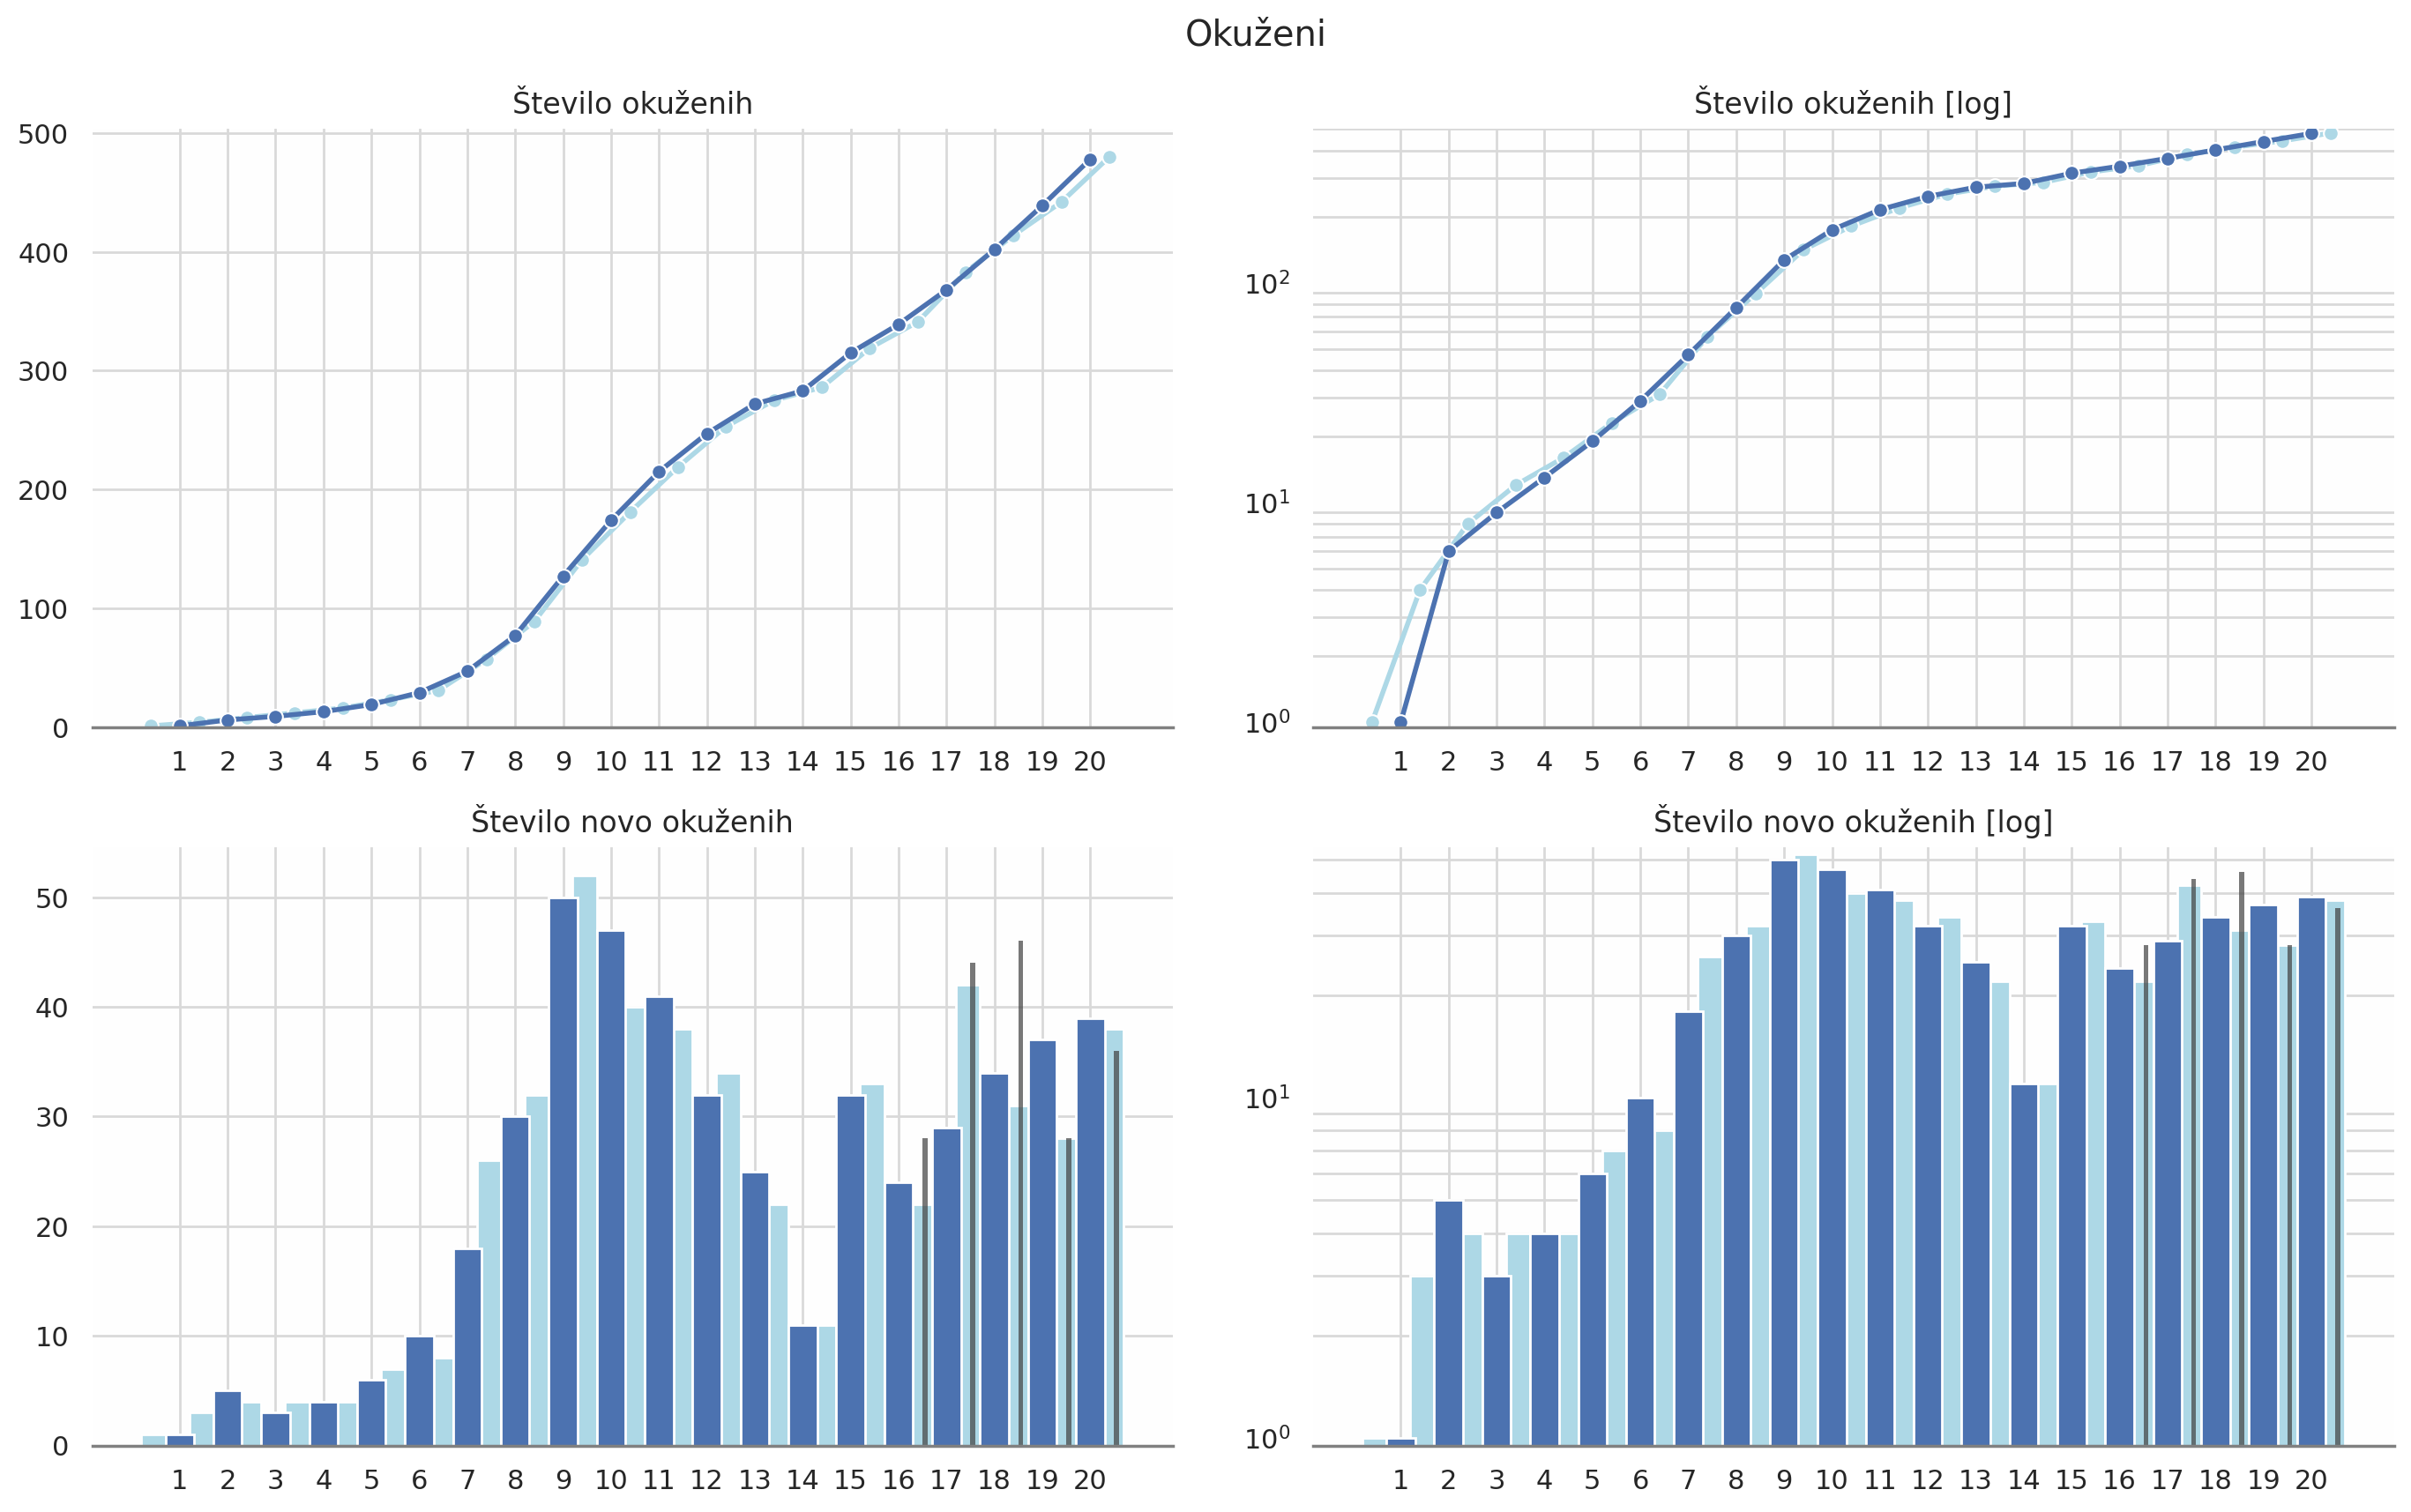

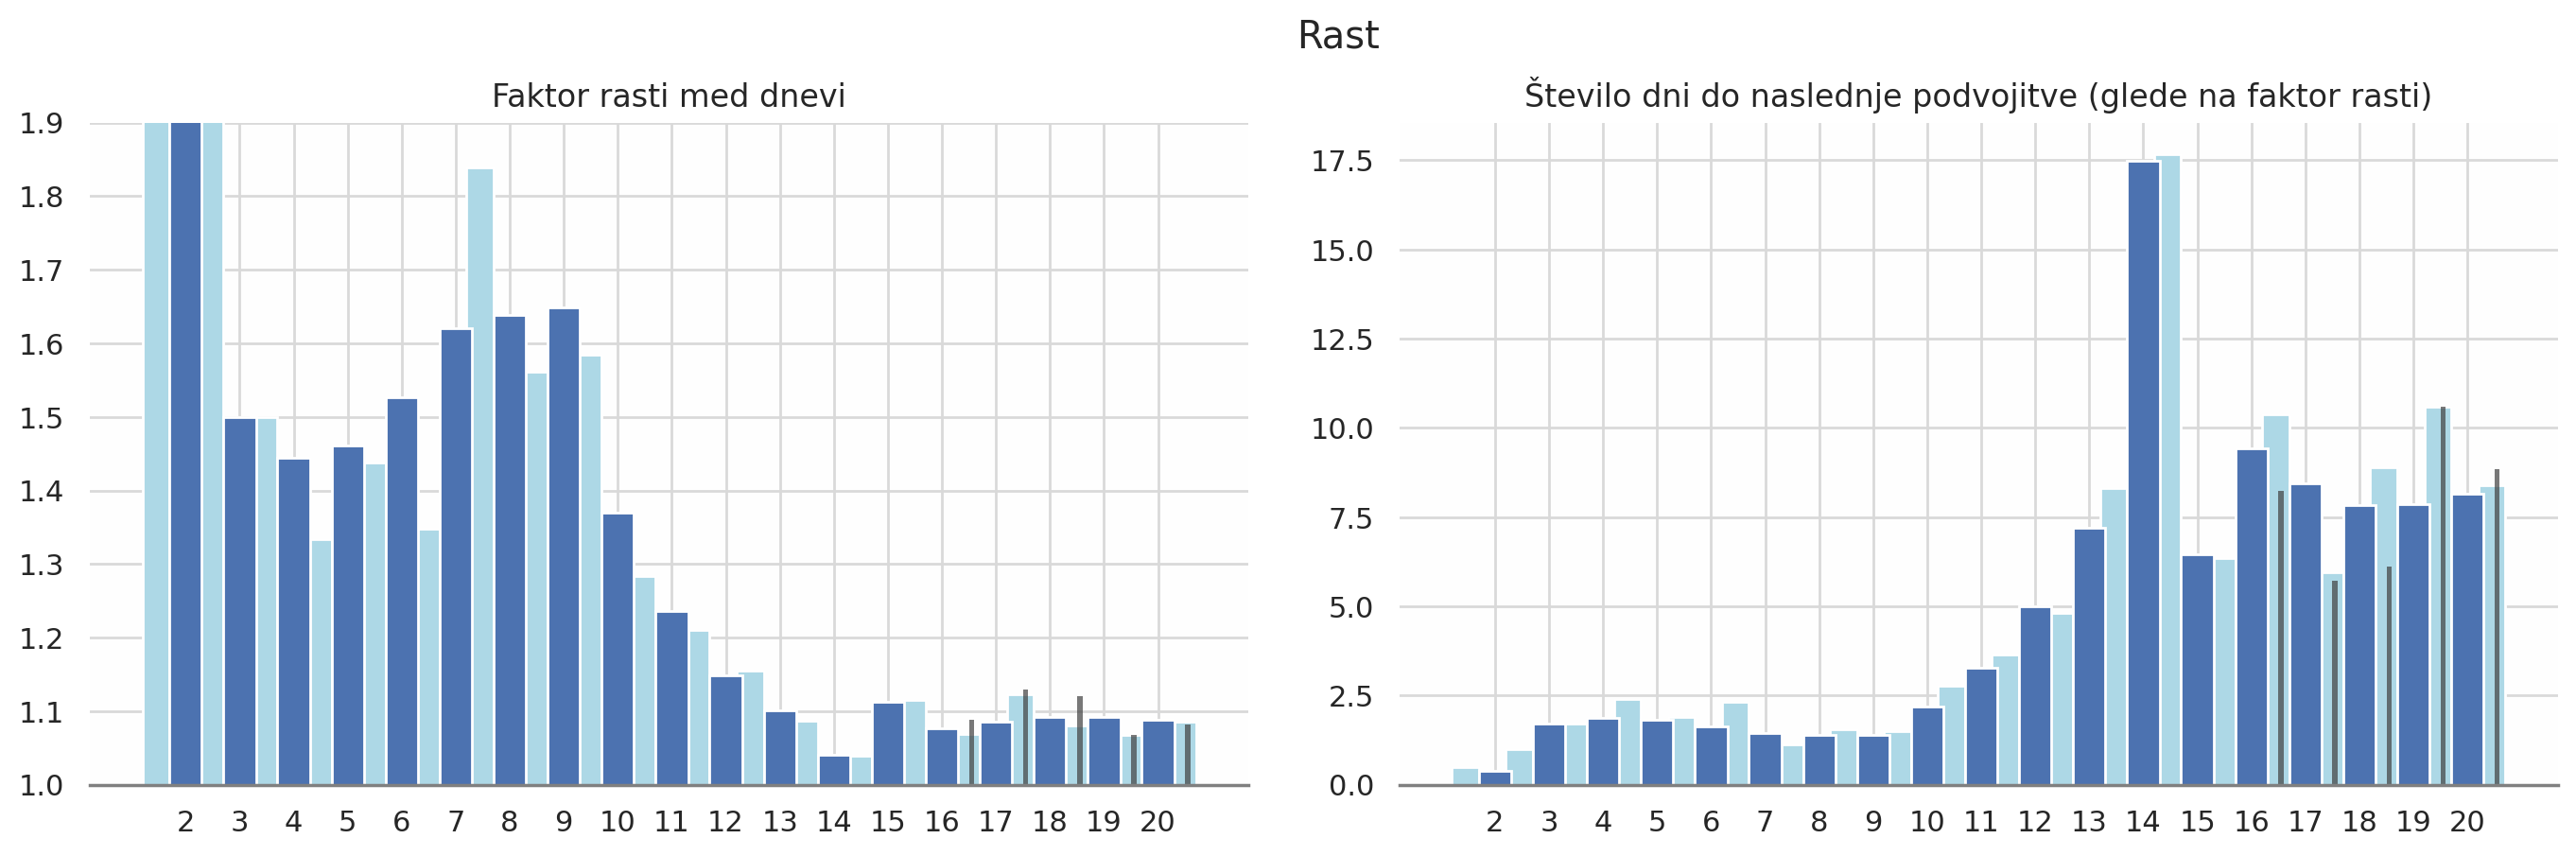

In [27]:
graf("okuženi")
graf("rast")

%%latex
\newpage

# Testirani

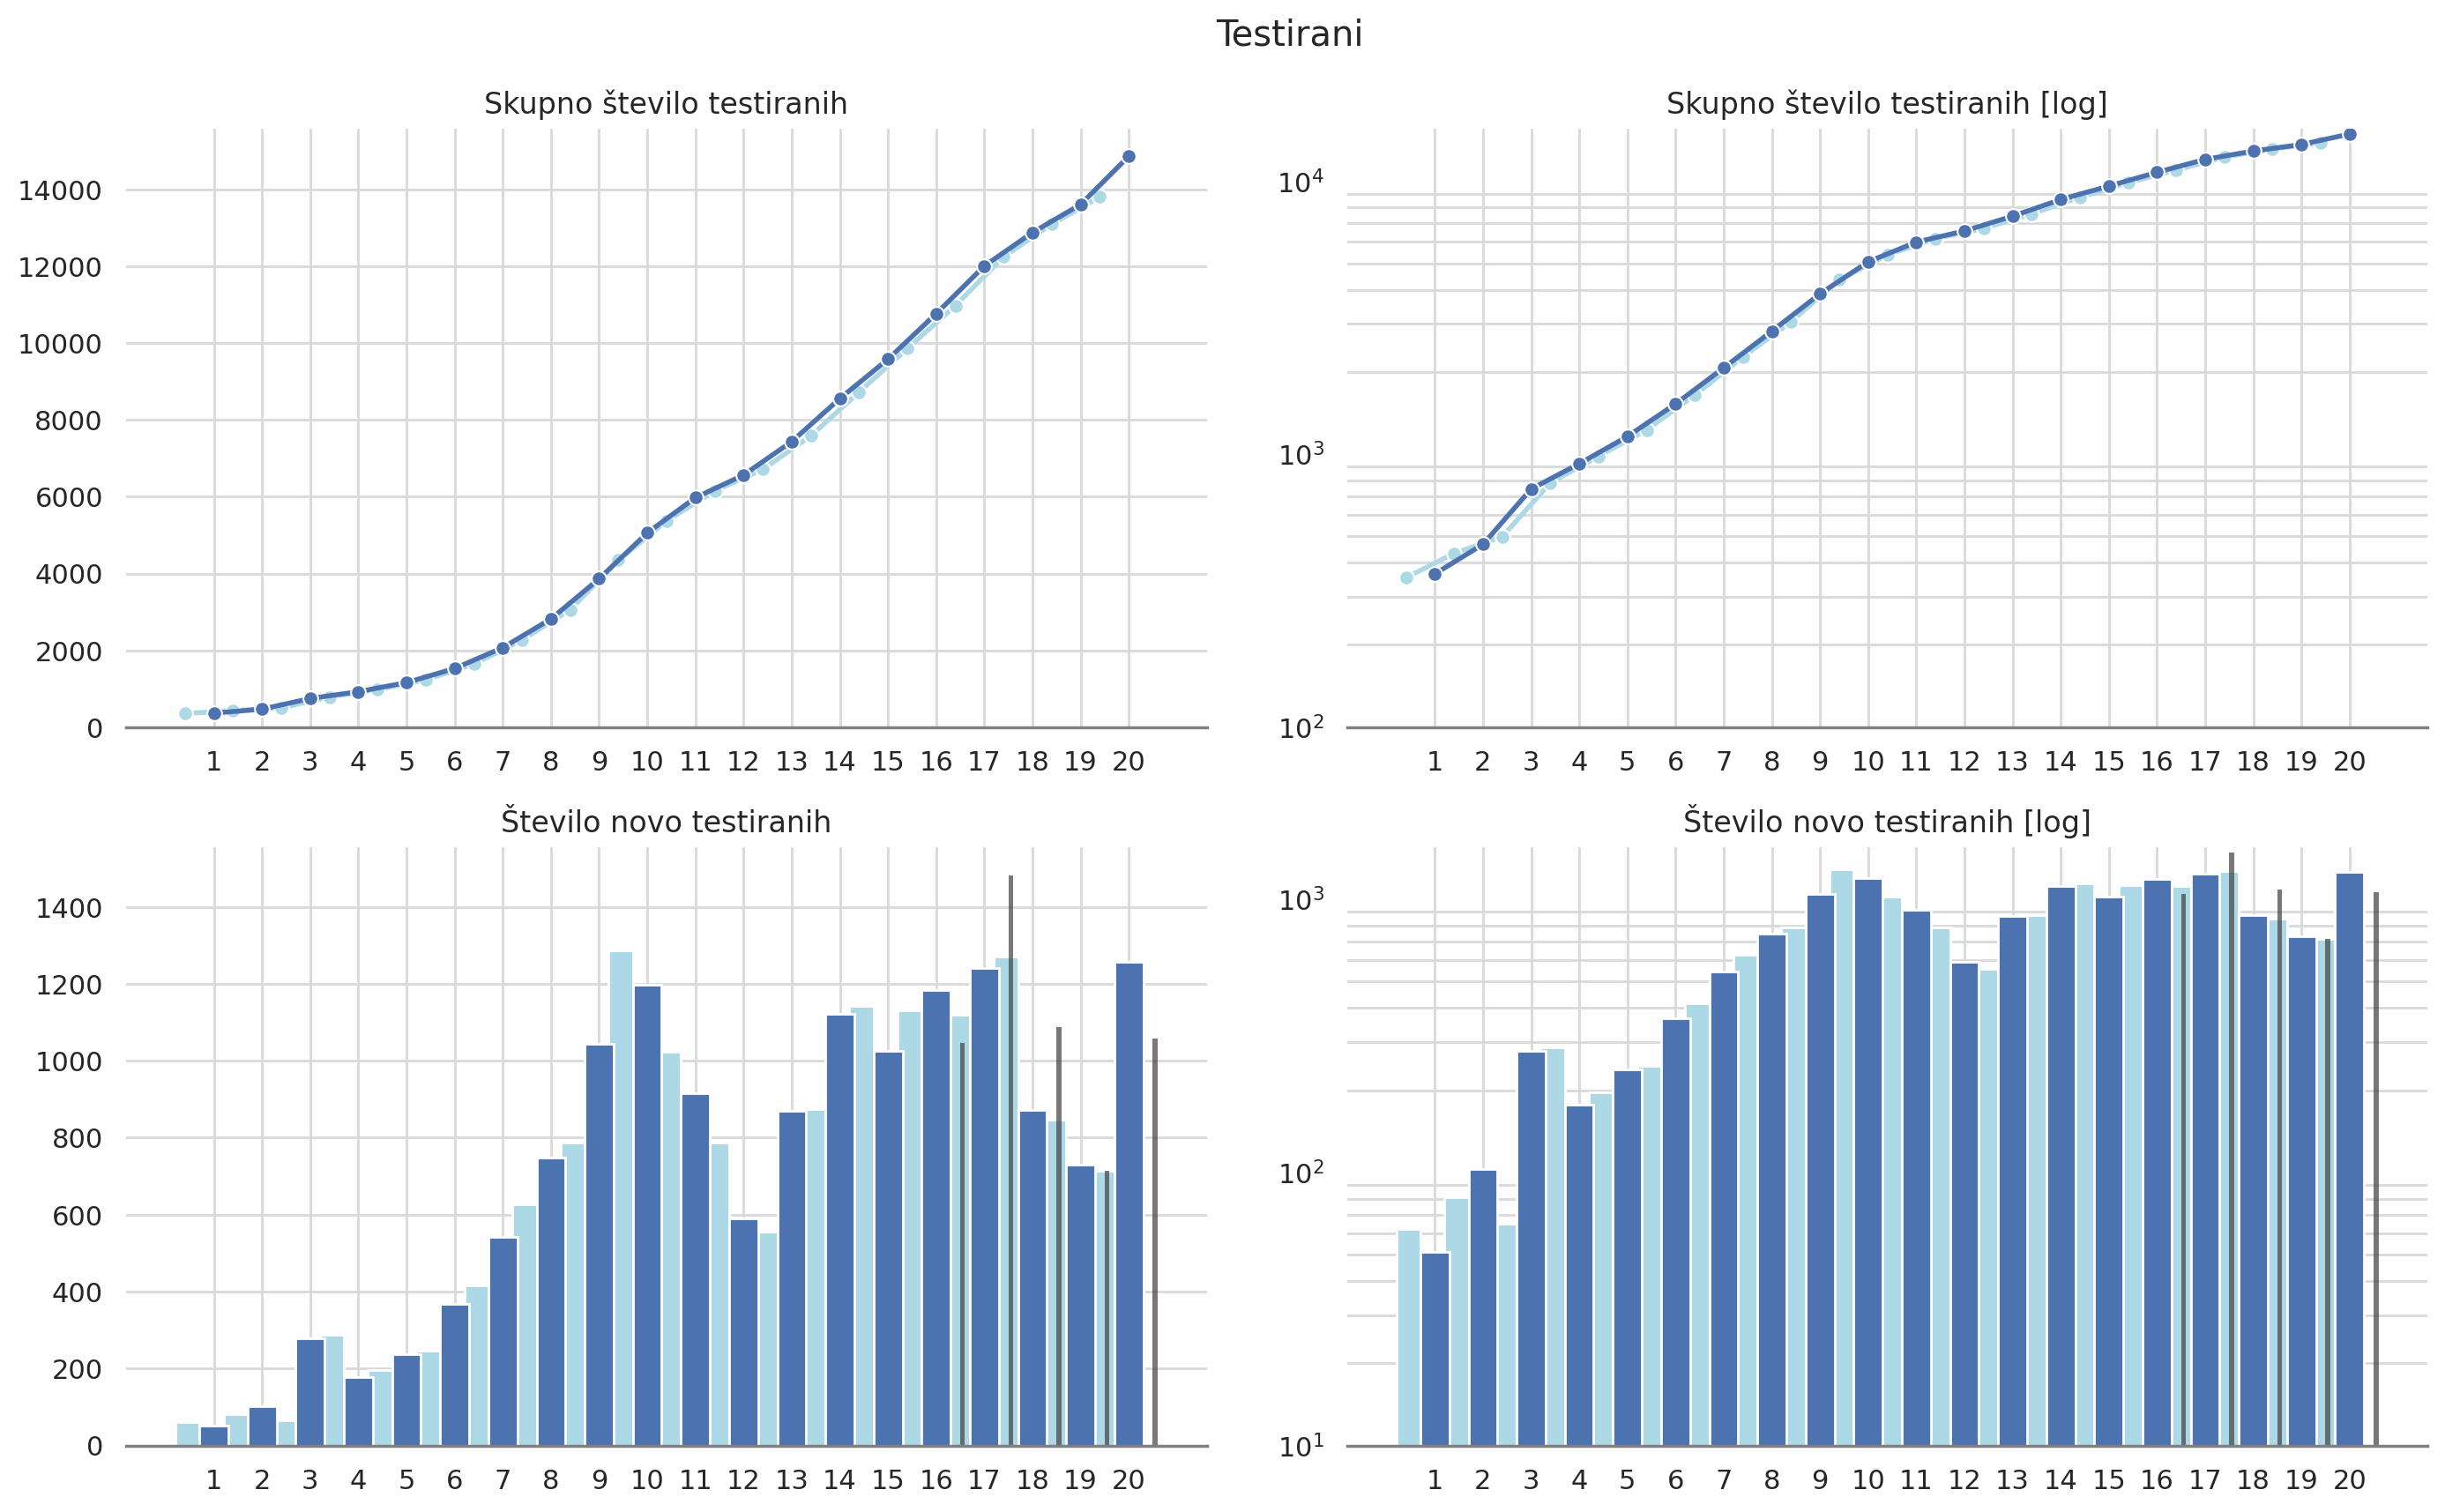

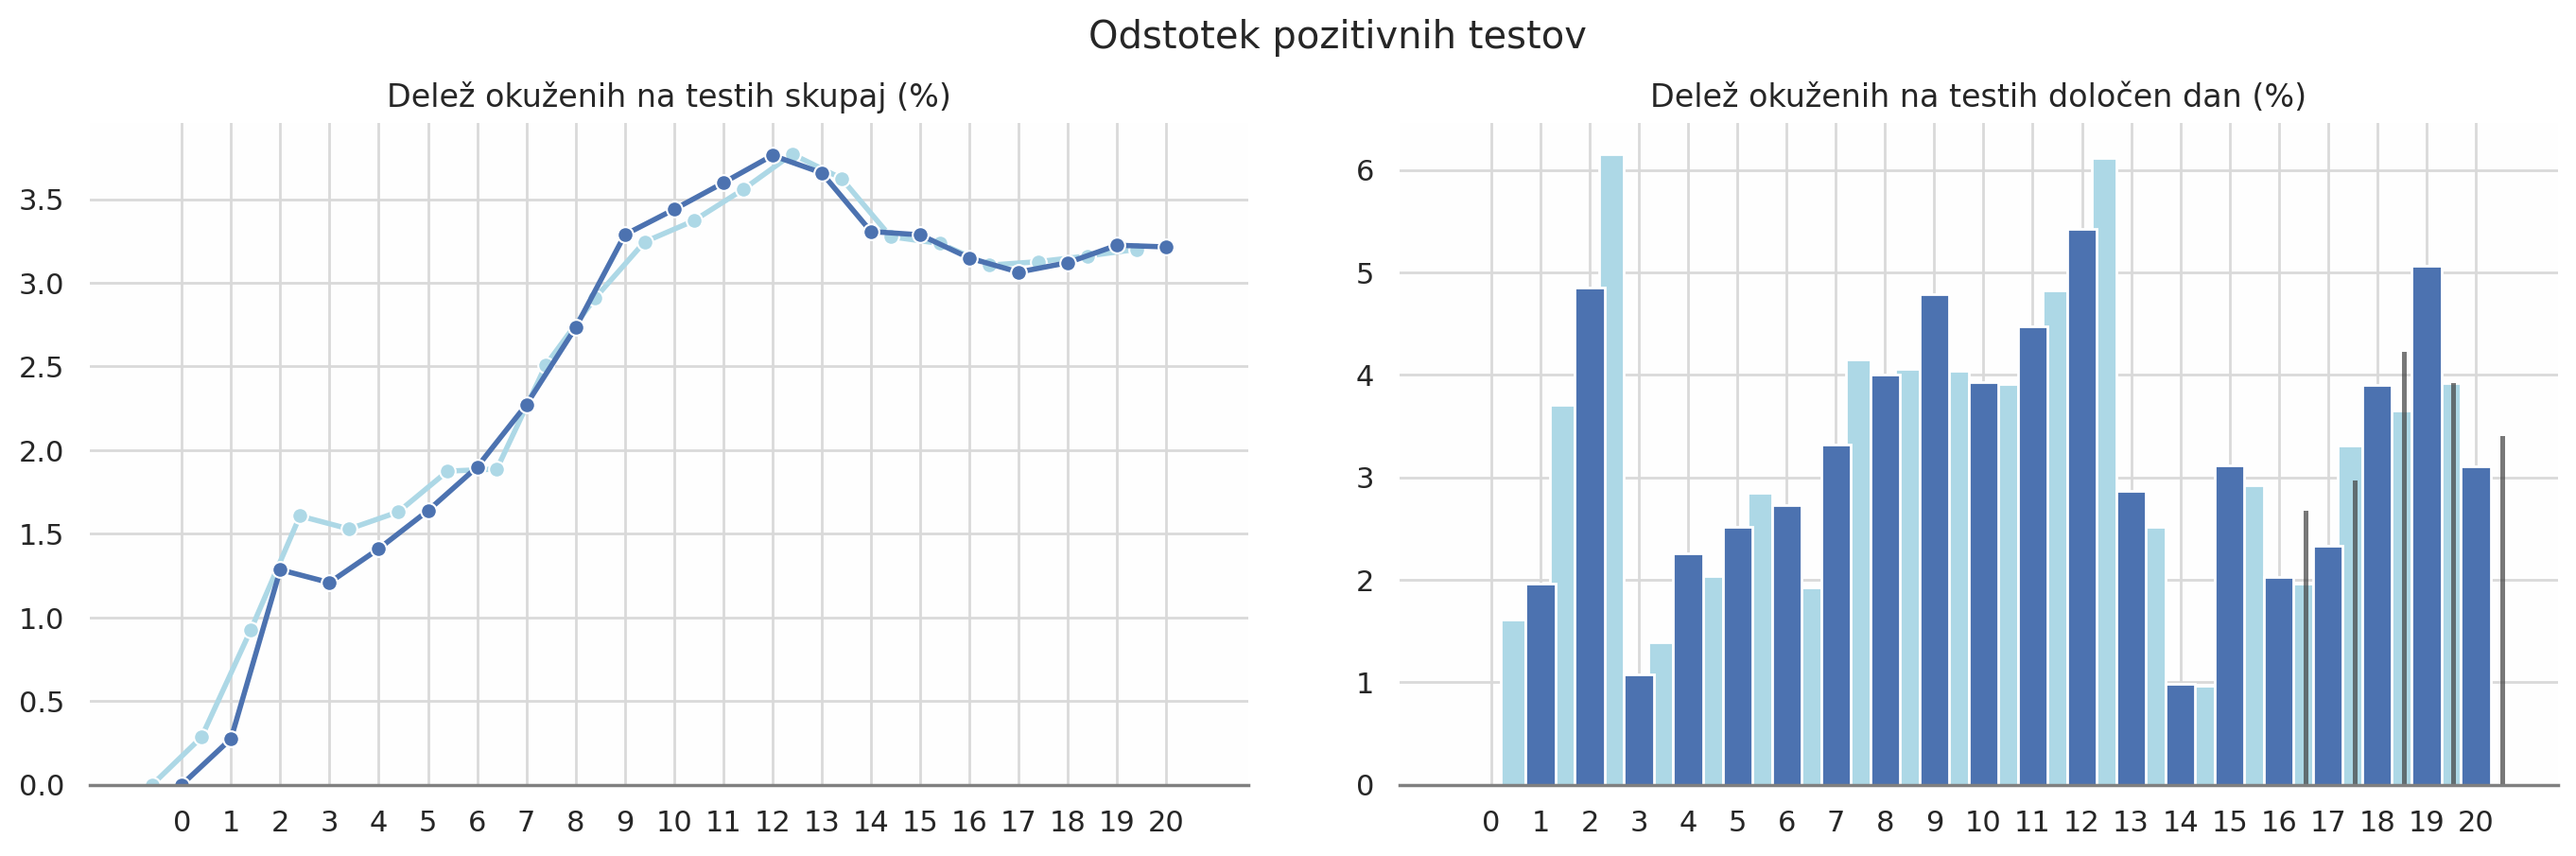

In [28]:
graf("testirani")
graf("procentualno")

%%latex
\newpage

# Hitrost rasti

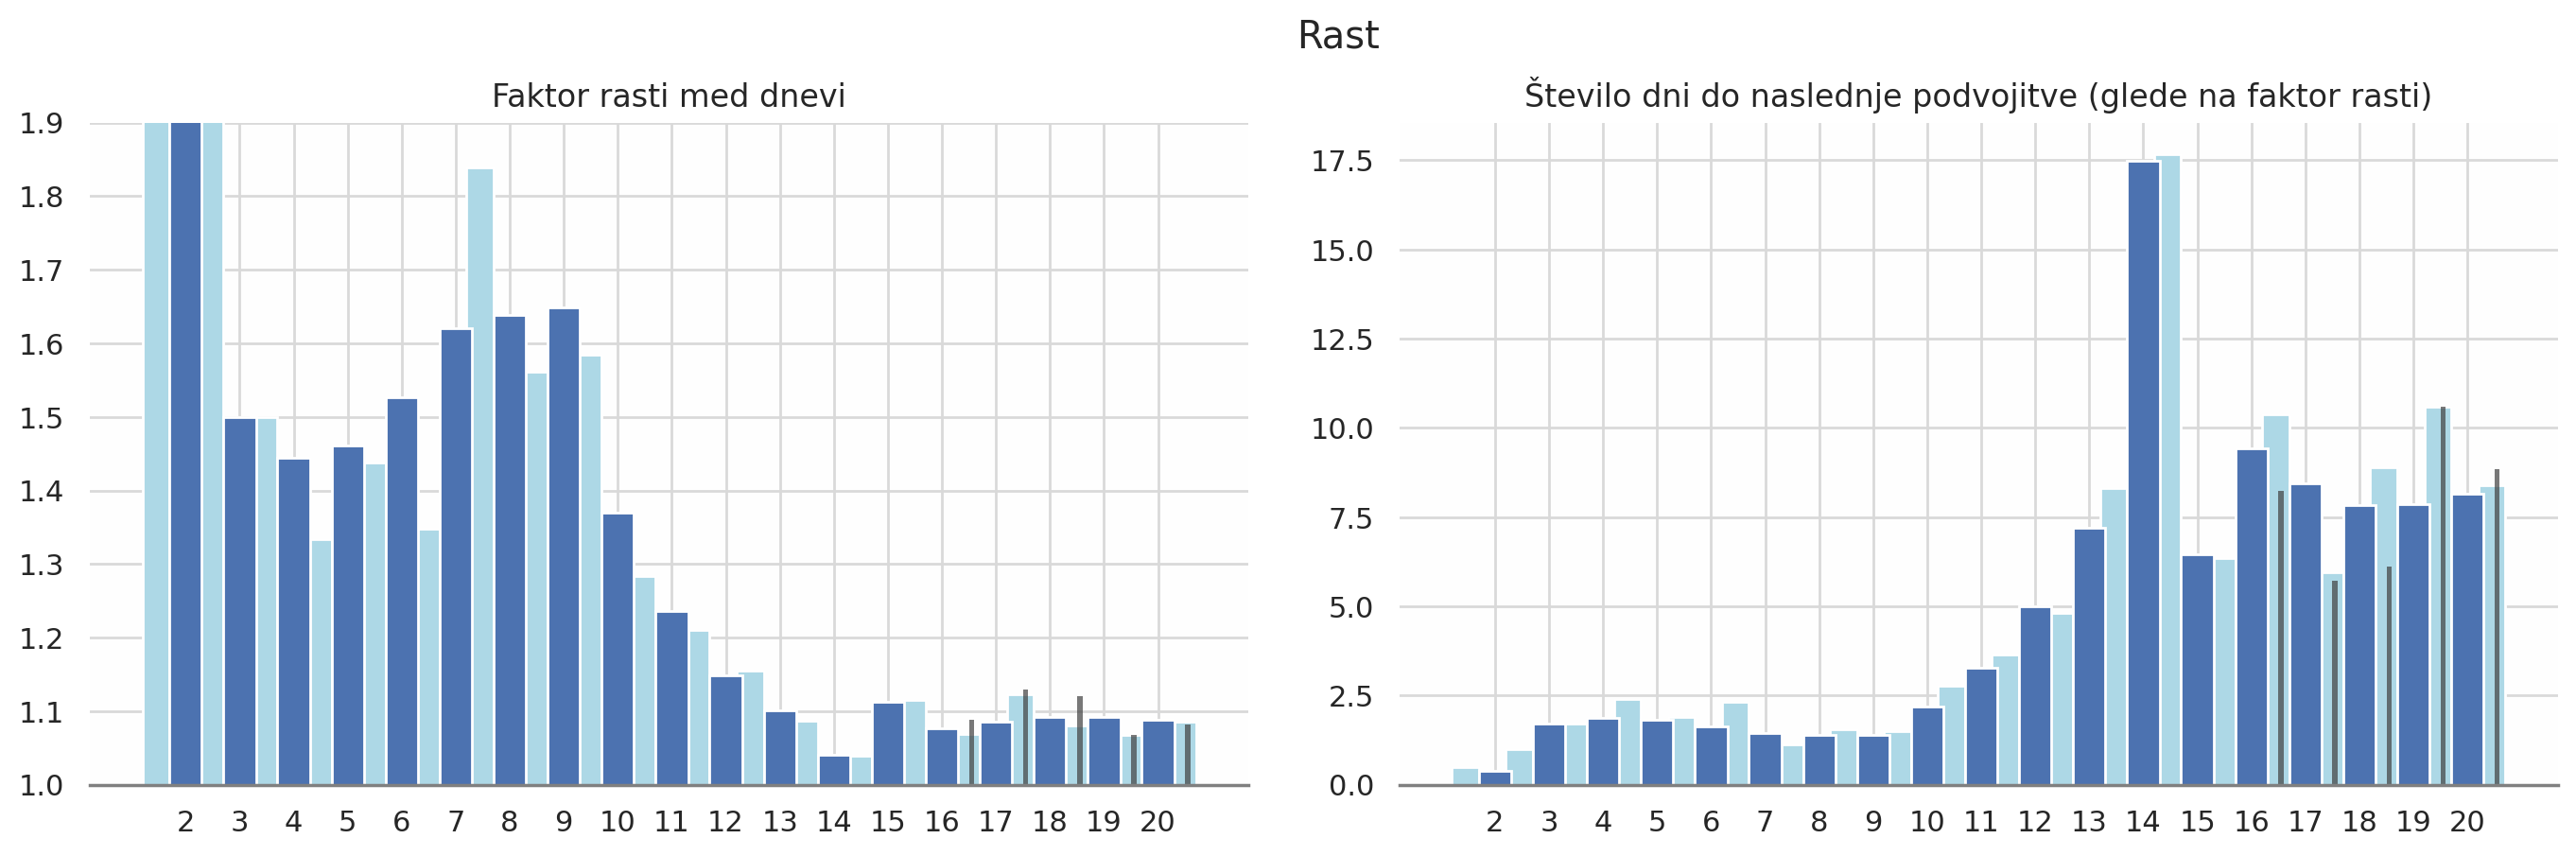

In [29]:
graf("rast", save=False)

$$ časPodvojitve = \frac{ln(2)}{ln(faktorRasti)} $$

**Povprečni faktor dnevne rasti** zadnjih 3 dni:

In [30]:
print("%.2f" % np.average(rast[-3:]))

1.09


**Čas podvojitve** števila okuženih *glede na faktor rasti zadnjega dne* in *povprečja zadnjih dveh dni*:

In [31]:
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnja dva dneva)" % dbl_d2)
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnji dan)" % dbl_d1)

Št. okuženih se bo podvojila čez 8.0 dni (glede na zadnja dva dneva)
Št. okuženih se bo podvojila čez 8.1 dni (glede na zadnji dan)


%%latex
\newpage

# Odstotek pozitivnih testov

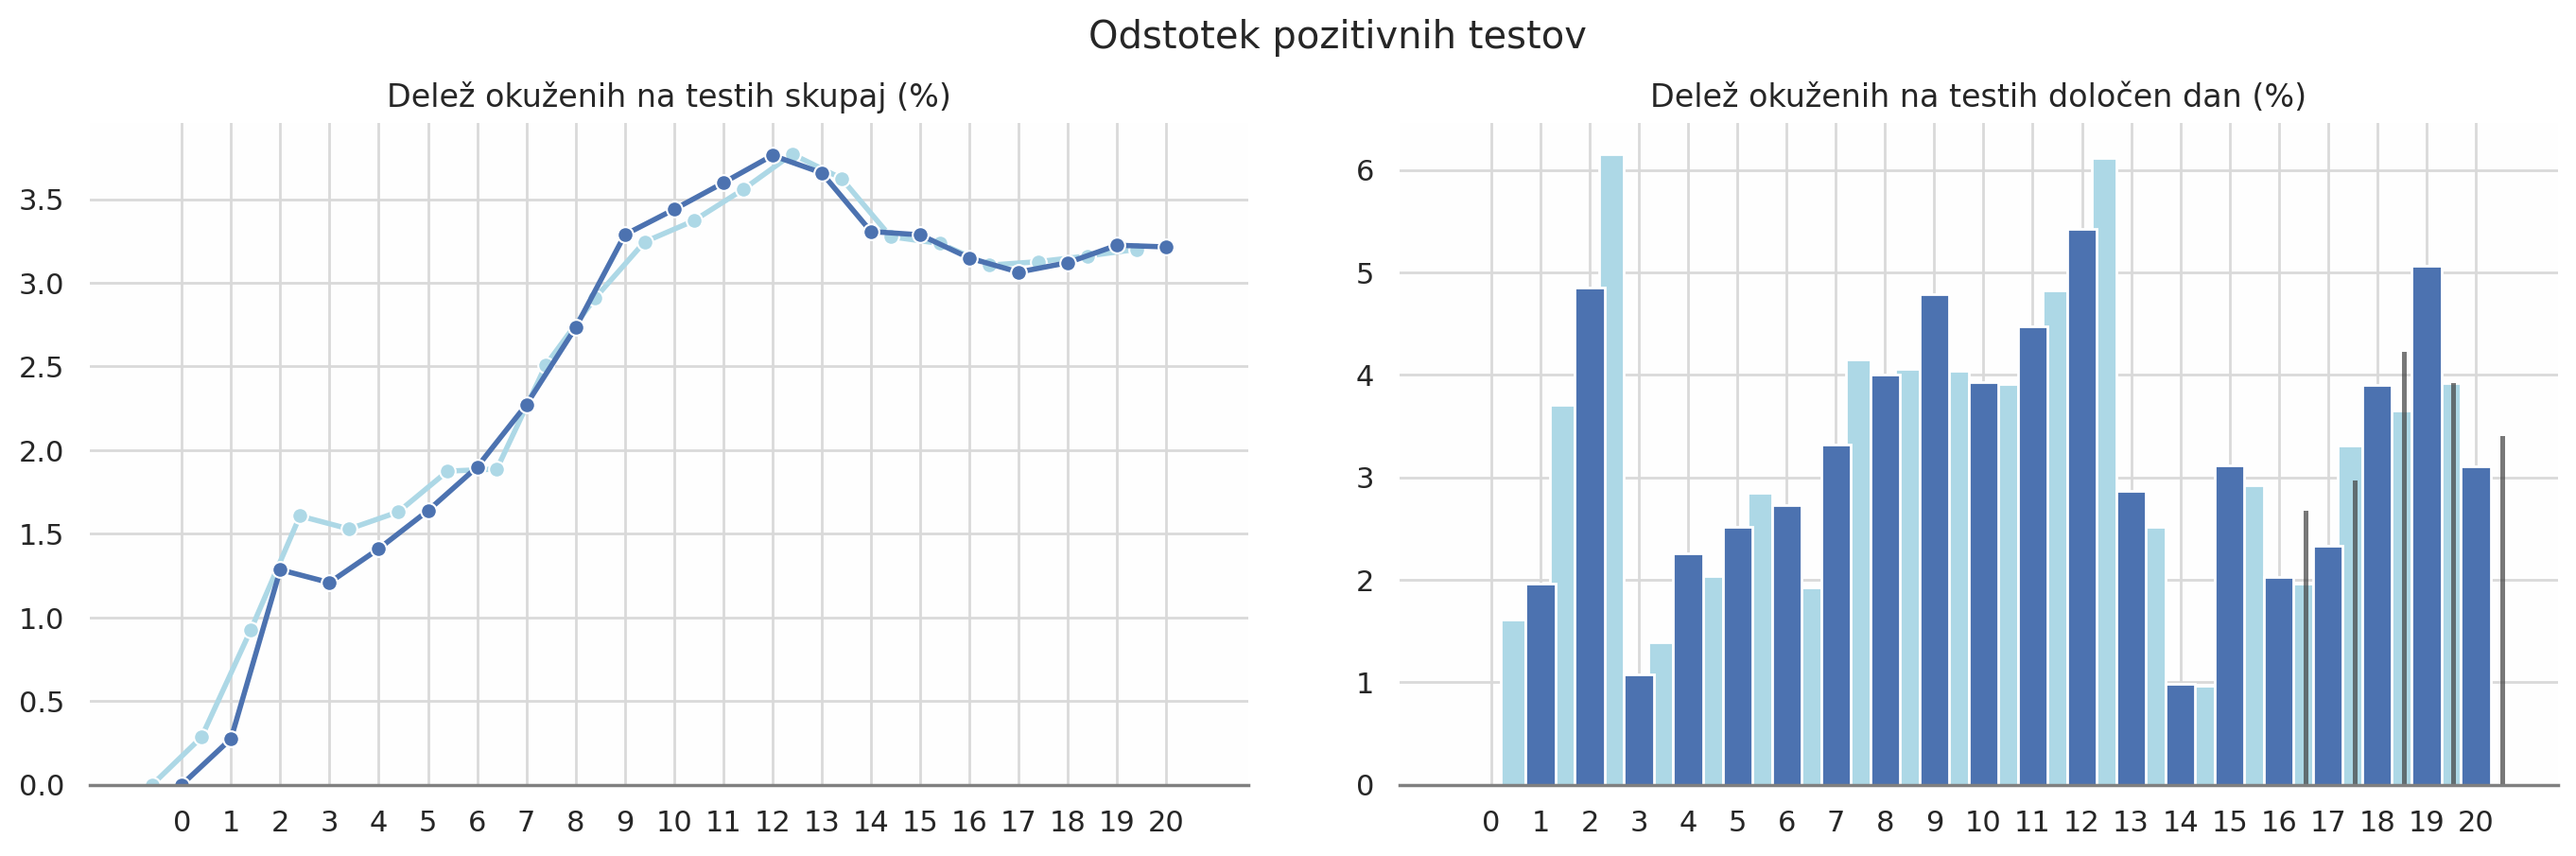

In [32]:
graf("procentualno", save=False)

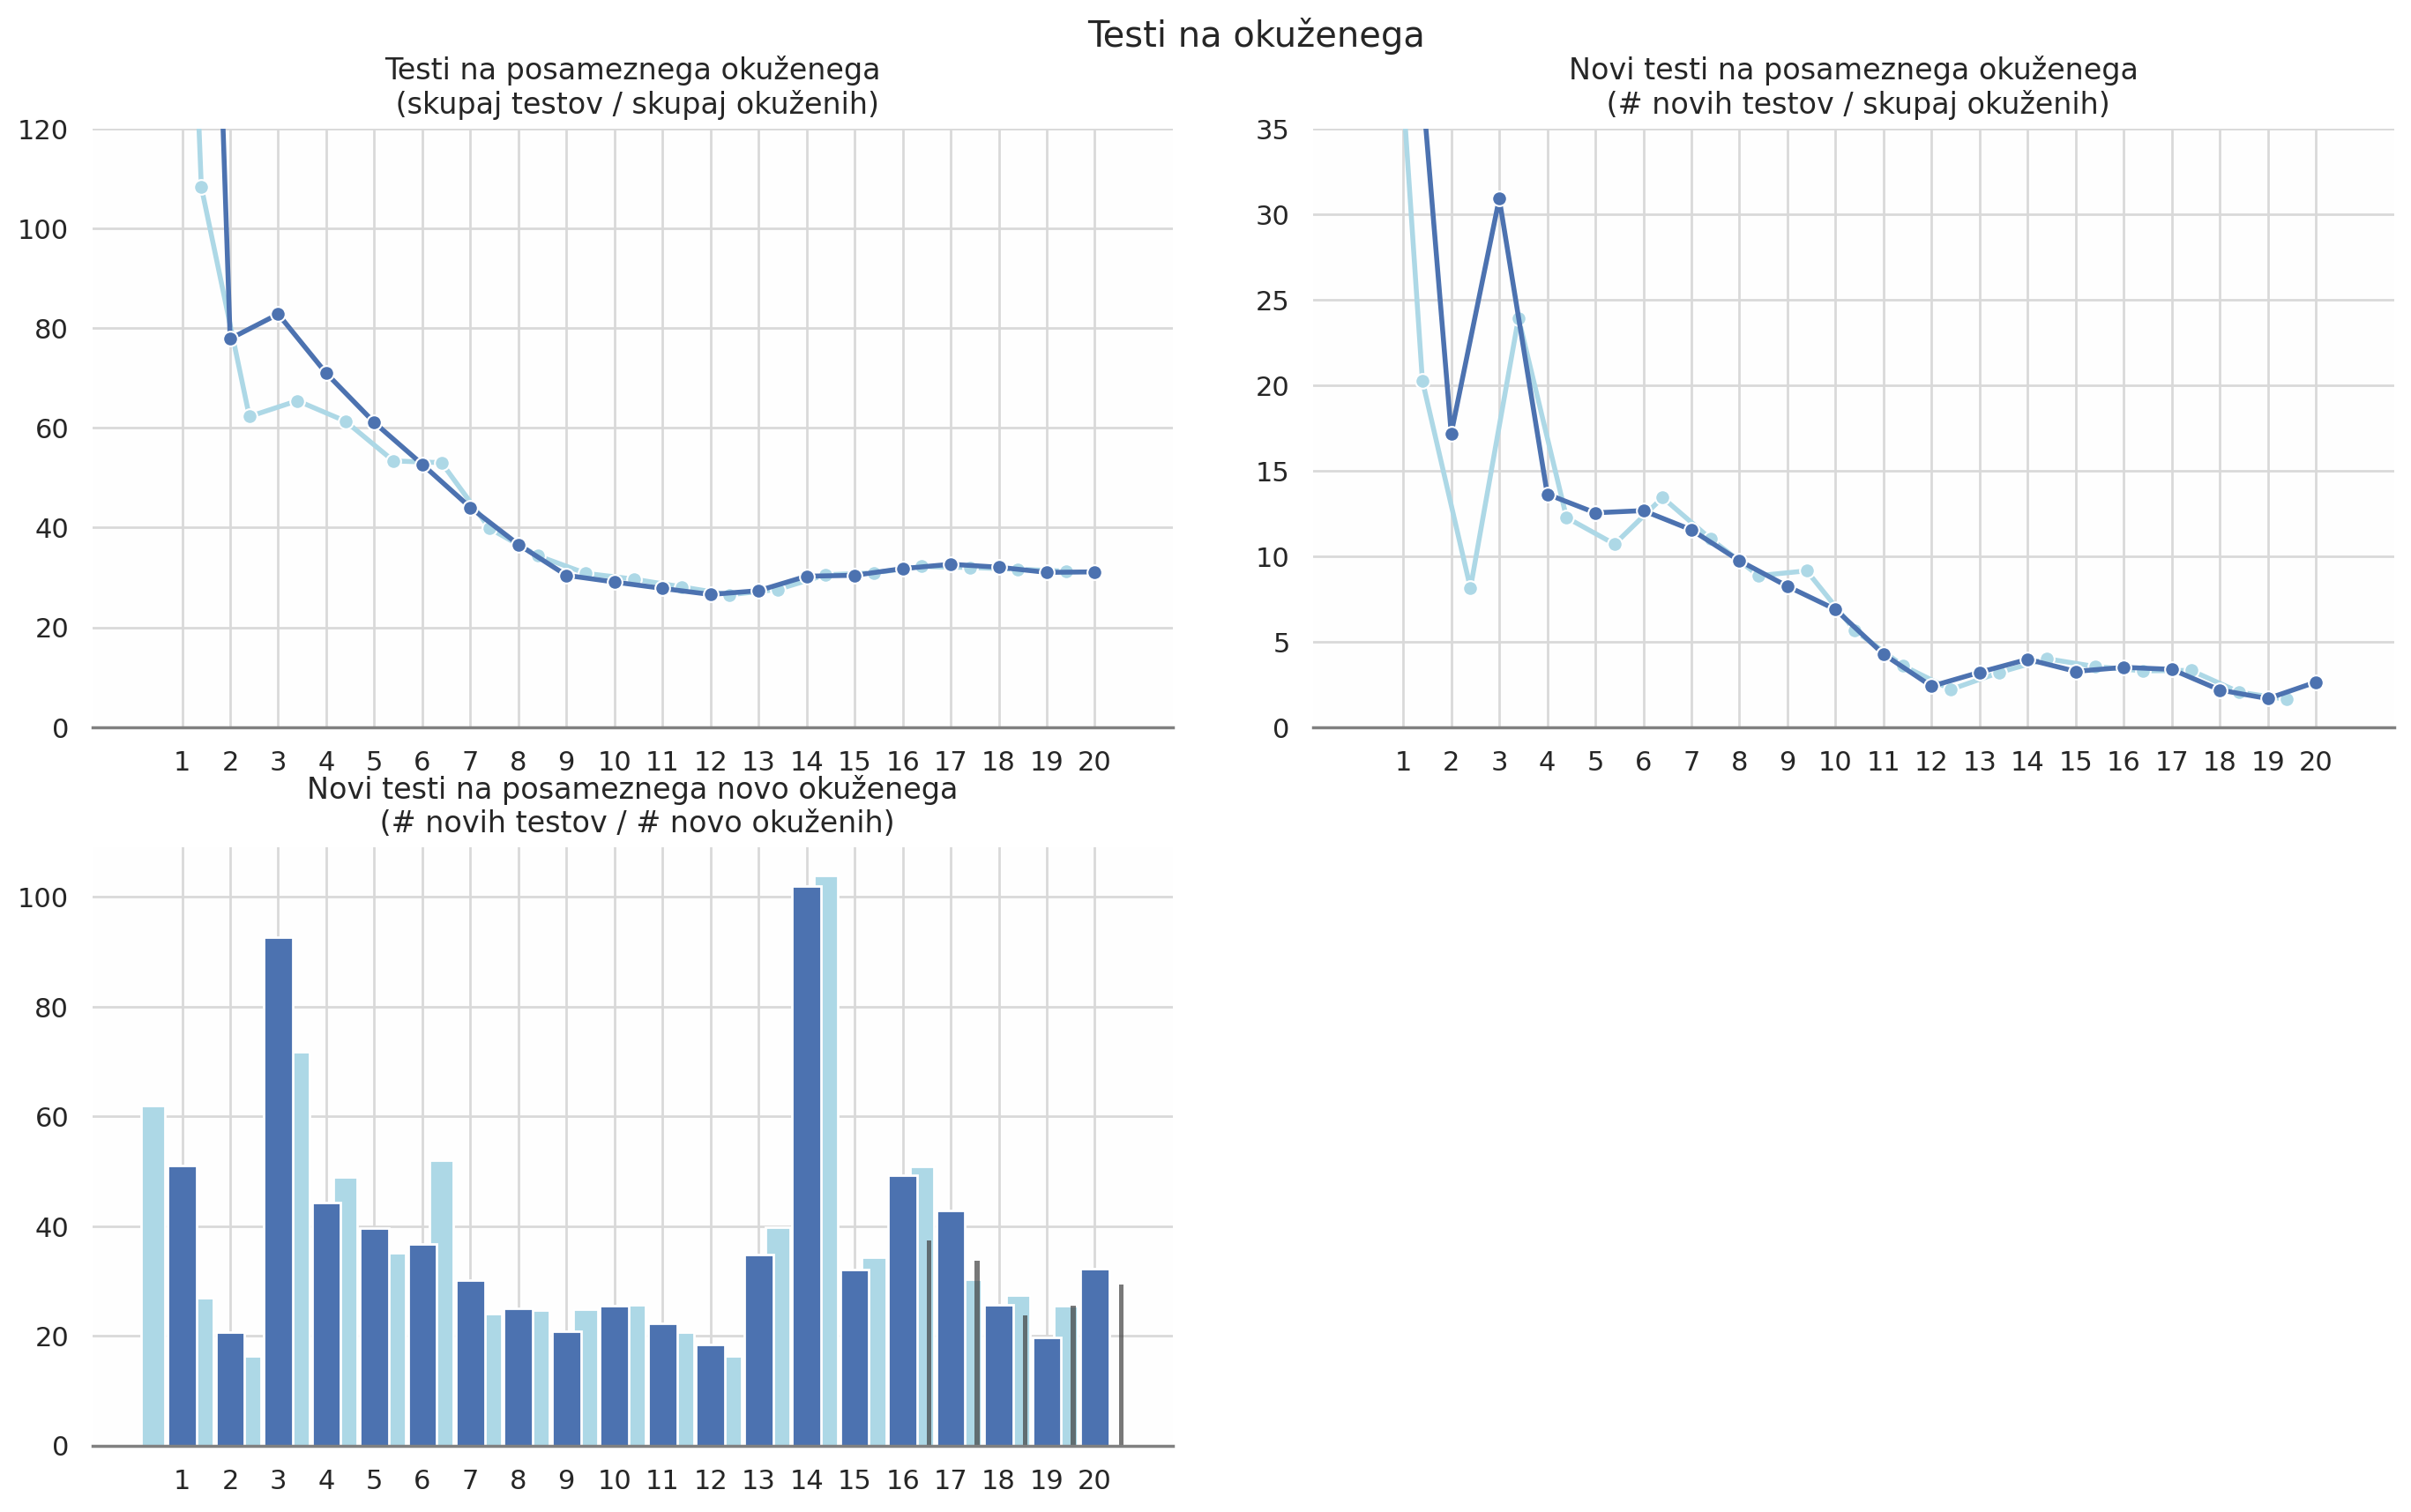

In [33]:
graf("na okuženega")

In [34]:
print("Ocena okuženih v Sloveniji ob (napačni) predpostavki,\nda so do sedaj testirani reprezentativen vzorec celotne populacije: "
     + str(int(odstotek_poz[-1]*2_000)*1000))

Ocena okuženih v Sloveniji ob (napačni) predpostavki,
da so do sedaj testirani reprezentativen vzorec celotne populacije: 64000


%%latex
\newpage

# Hospitalizirani

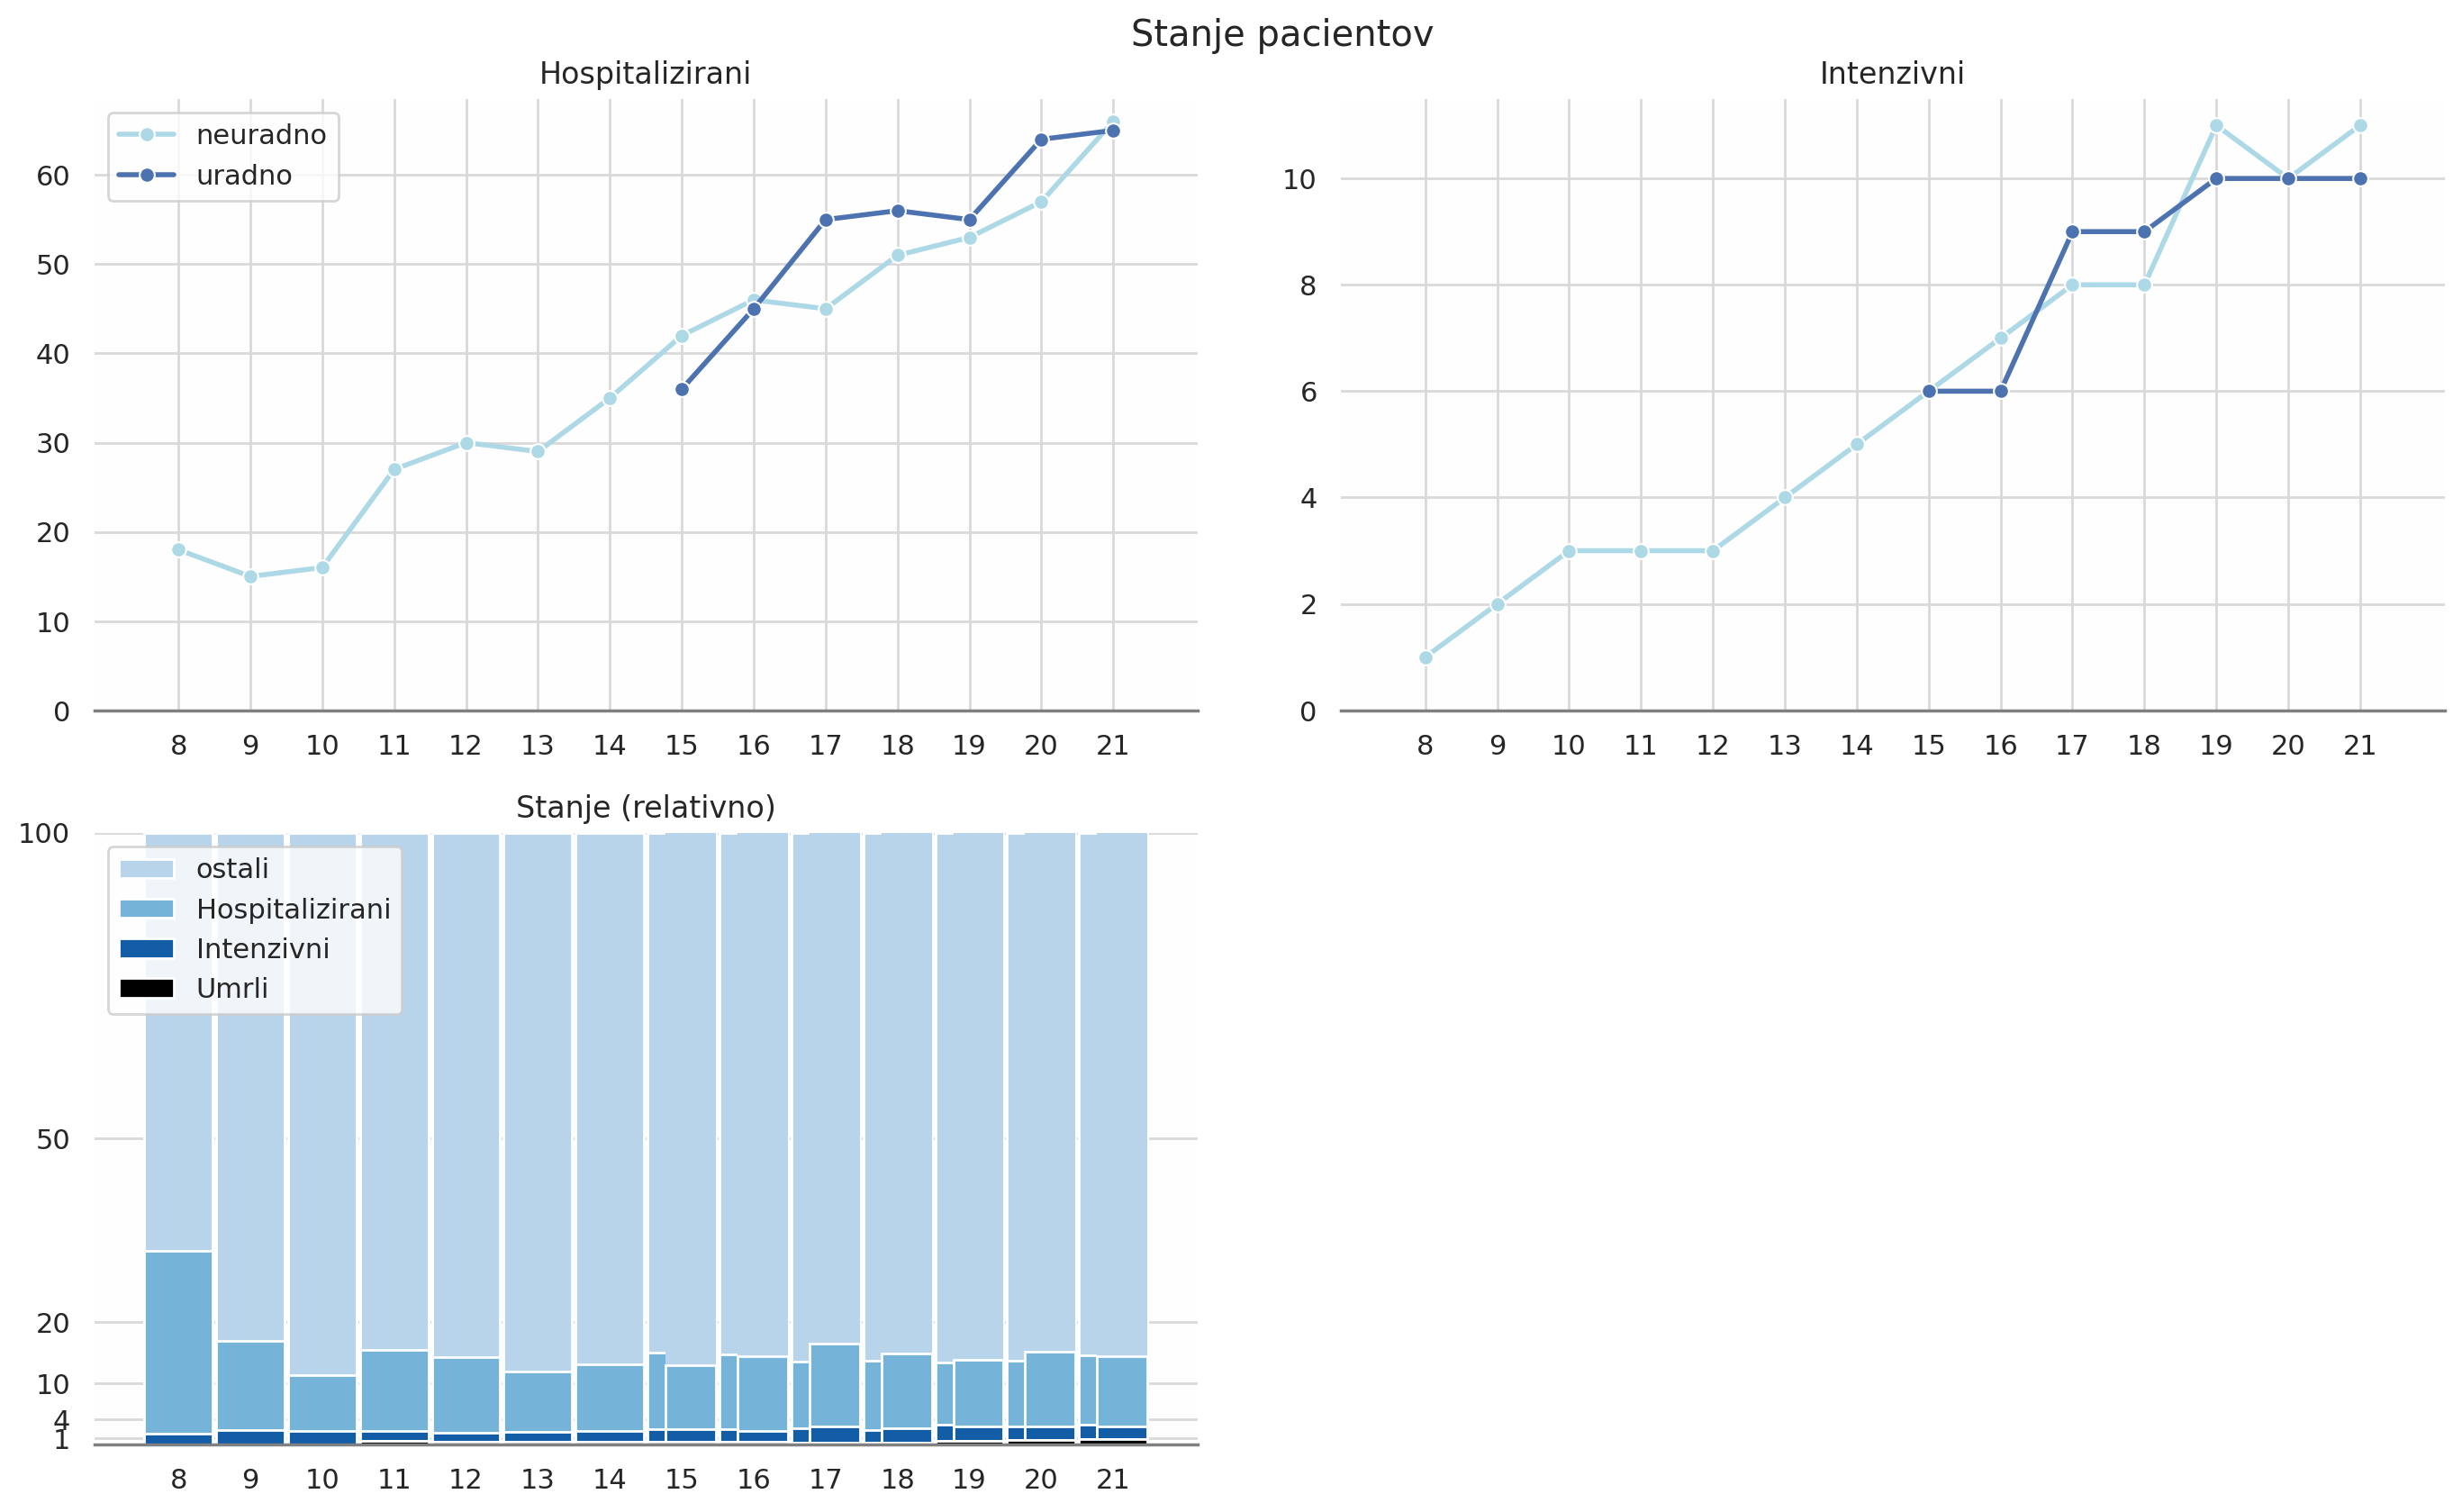

In [35]:
graf("hospitalizirani primerjava")

%%latex
\newpage

# Po starosti

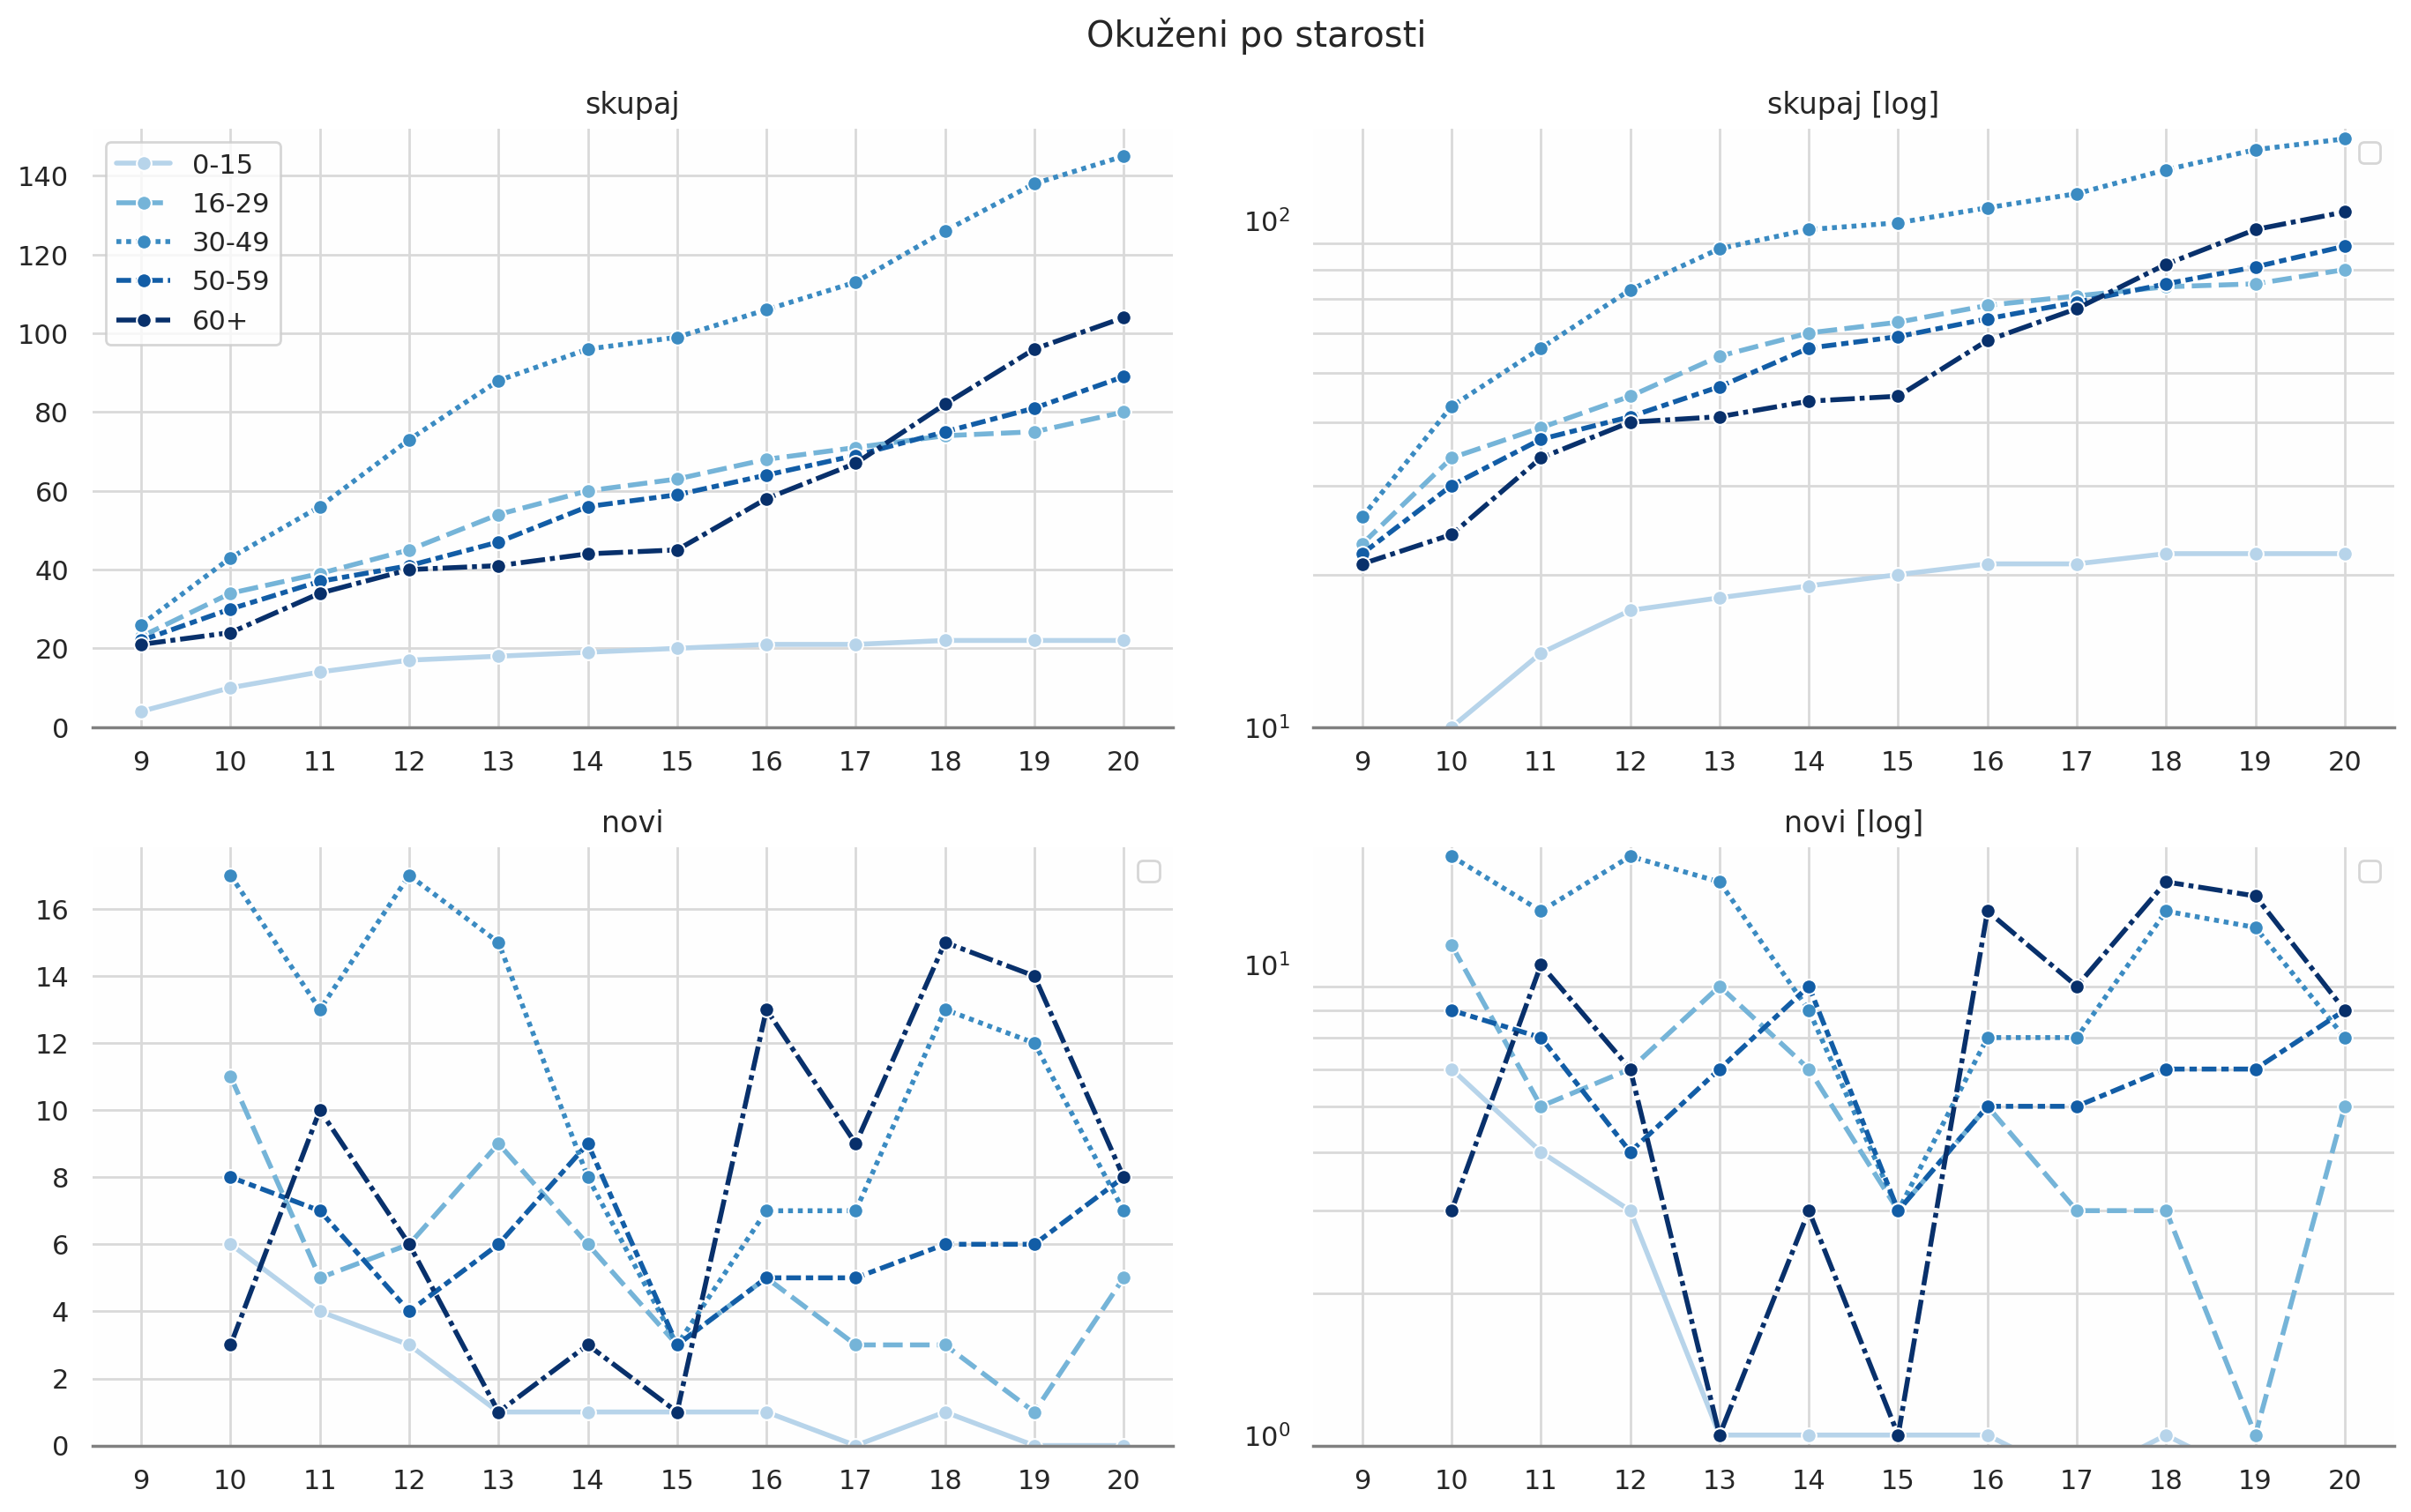

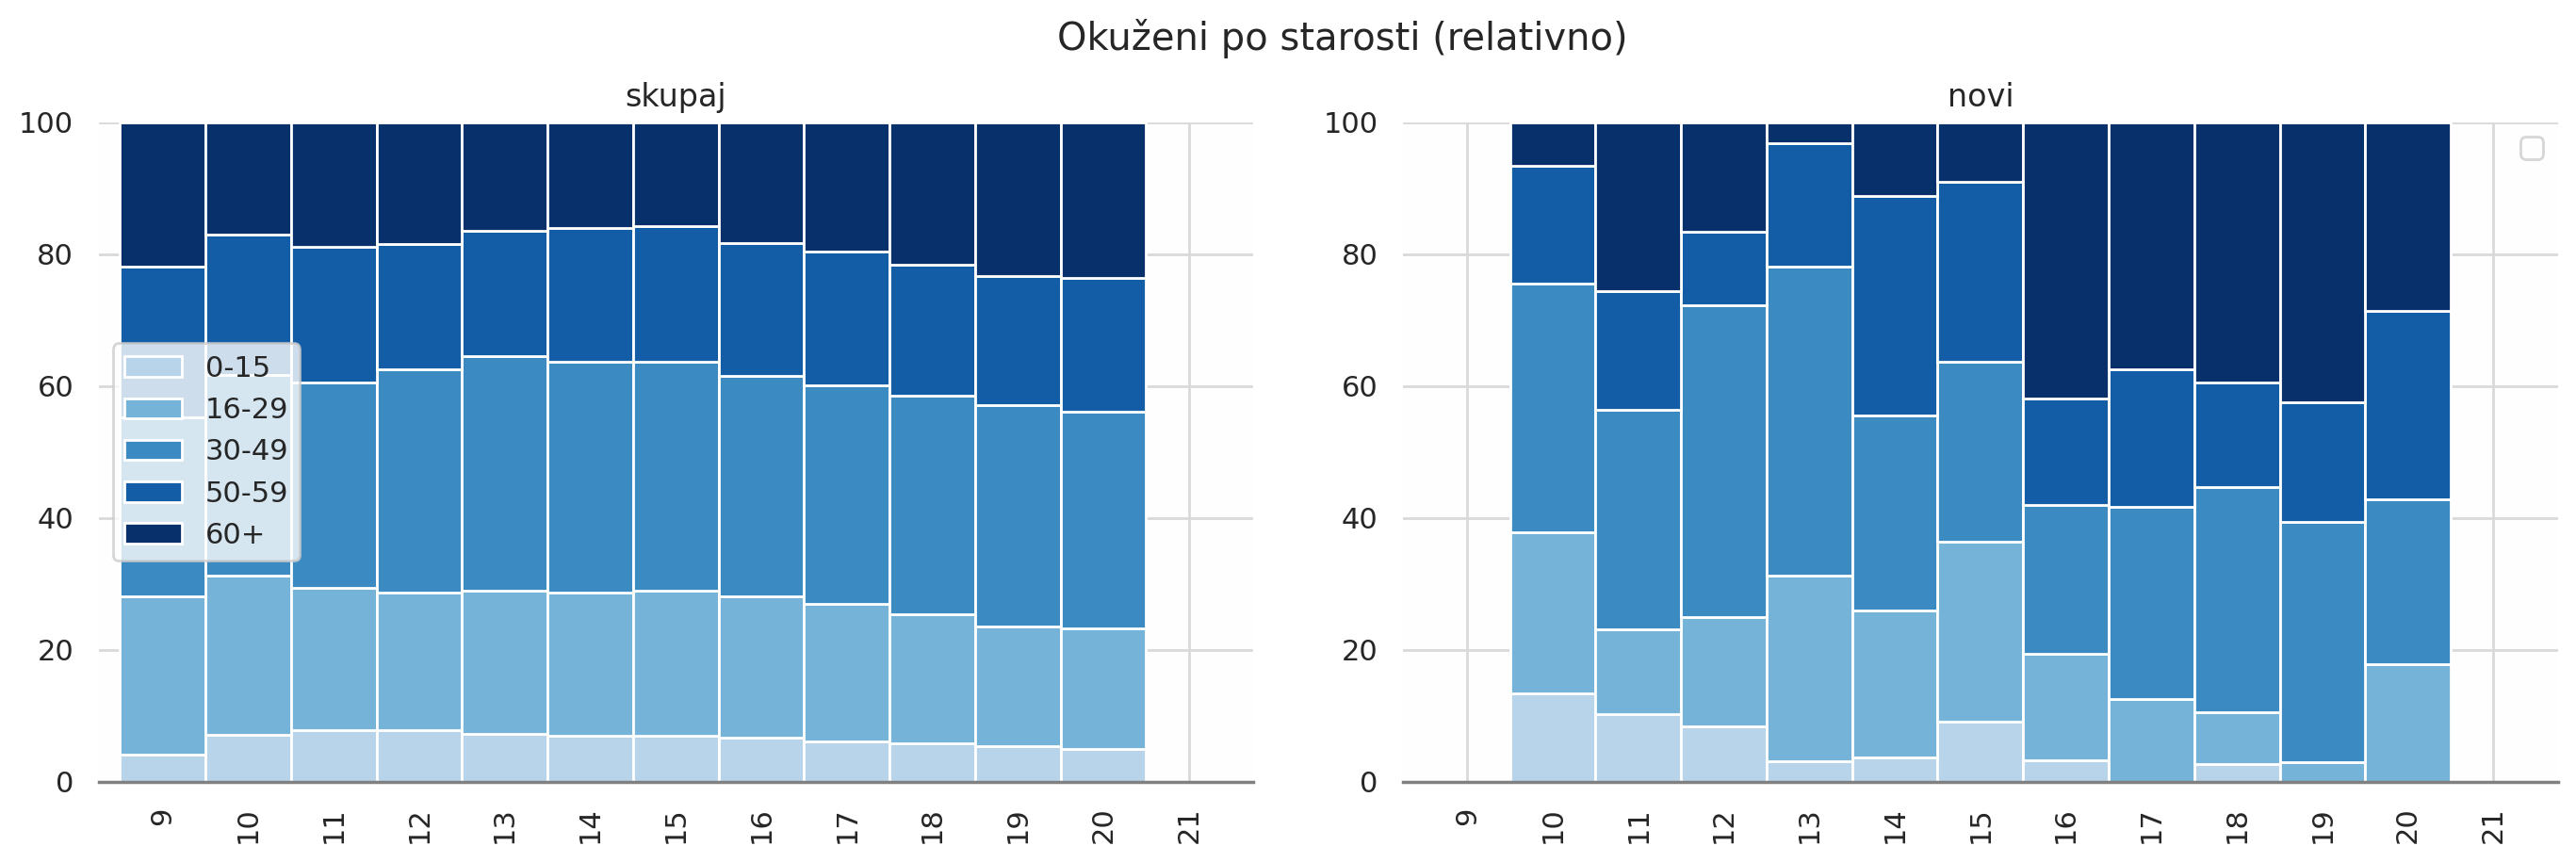

In [197]:
graf("starosti")

%%latex
\newpage

# Po regijah

In [205]:
graf("regije")
graf("regije relativno")
graf("regije na populacijo")

---

%%latex
\newpage

# Iskanje prilegajoče eksponentne funkcije

$$ f(x) = a^{x - b} $$

Najdeni paremetri funkcije:

In [38]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a, b, a, b))

a = 1.14
b = -28.49

f(x) = 1.14 ^ (x - (-28.49))


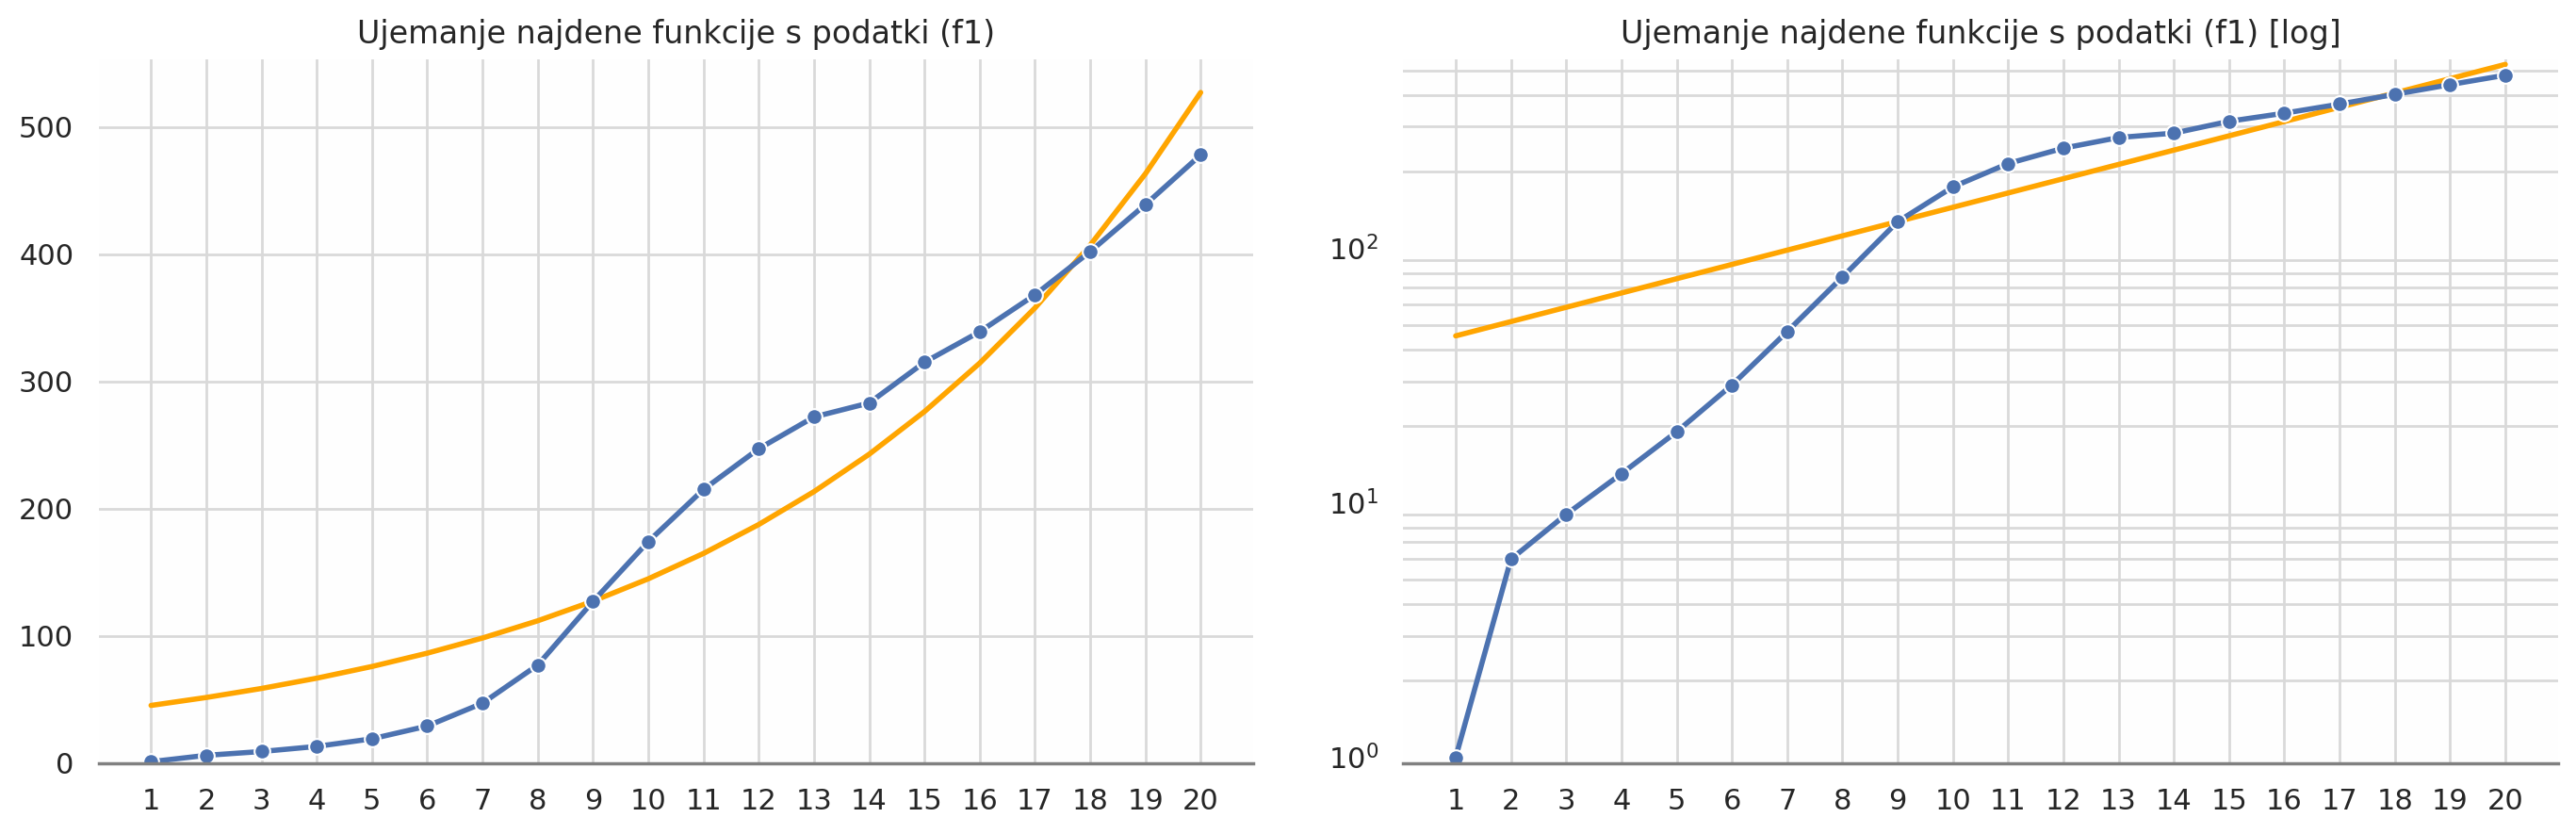

In [39]:
graf("f1", "ujemanje")

**Čas podovijitve** števila okuženih:

In [40]:
print("Št. okuženih se podvoji na %.1f dni." % dbl1)

Št. okuženih se podvoji na 5.4 dni.


%%latex
\newpage

## Napoved za naprej

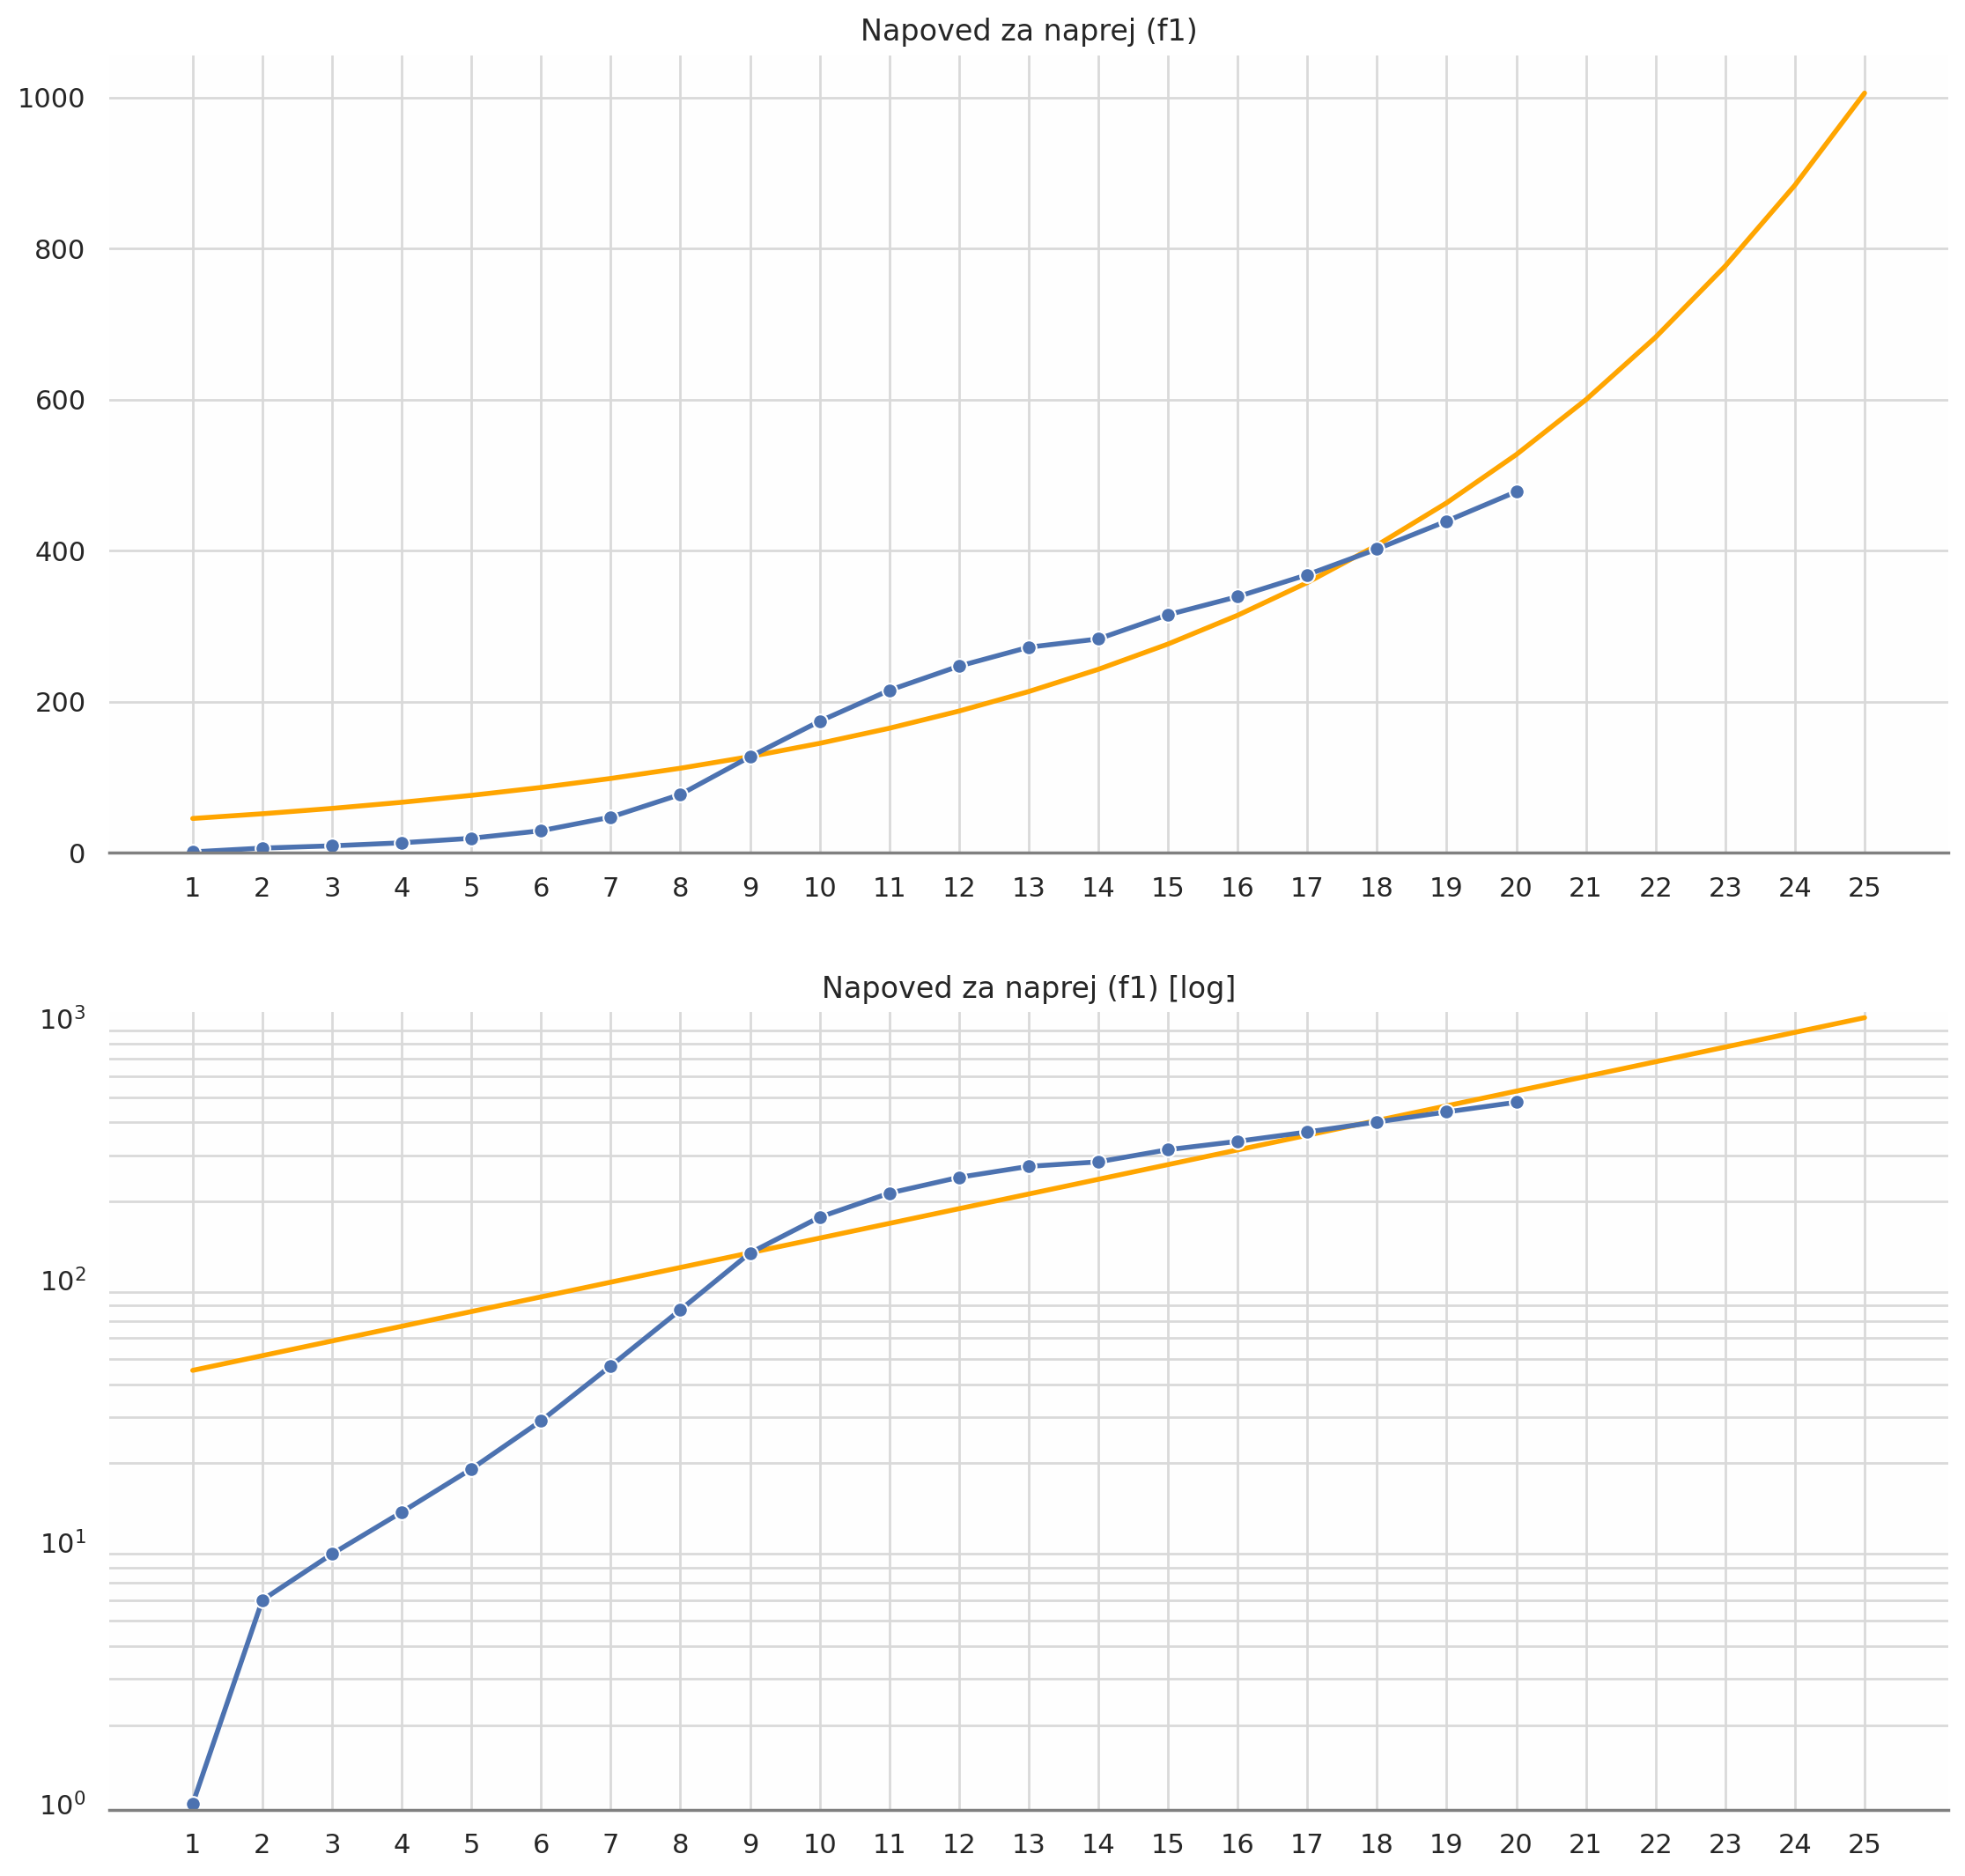

In [41]:
graf("f1", "napoved")

%%latex
\newpage

# Iskanje prilegajoče linearne funkcije na logaritmiranih podatkih

$$ f(x) = k * x + n $$

Najdeni parametri linearne funkcije:

In [42]:
print("k = %.2f\nn = %.2f\n\nf(x) = %.2f * x + %.2f" % (k, n, k, n))

k = 0.10
n = 0.96

f(x) = 0.10 * x + 0.96


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [43]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a1, b1, a1, b1))

a = 1.26
b = -9.18

f(x) = 1.26 ^ (x - (-9.18))


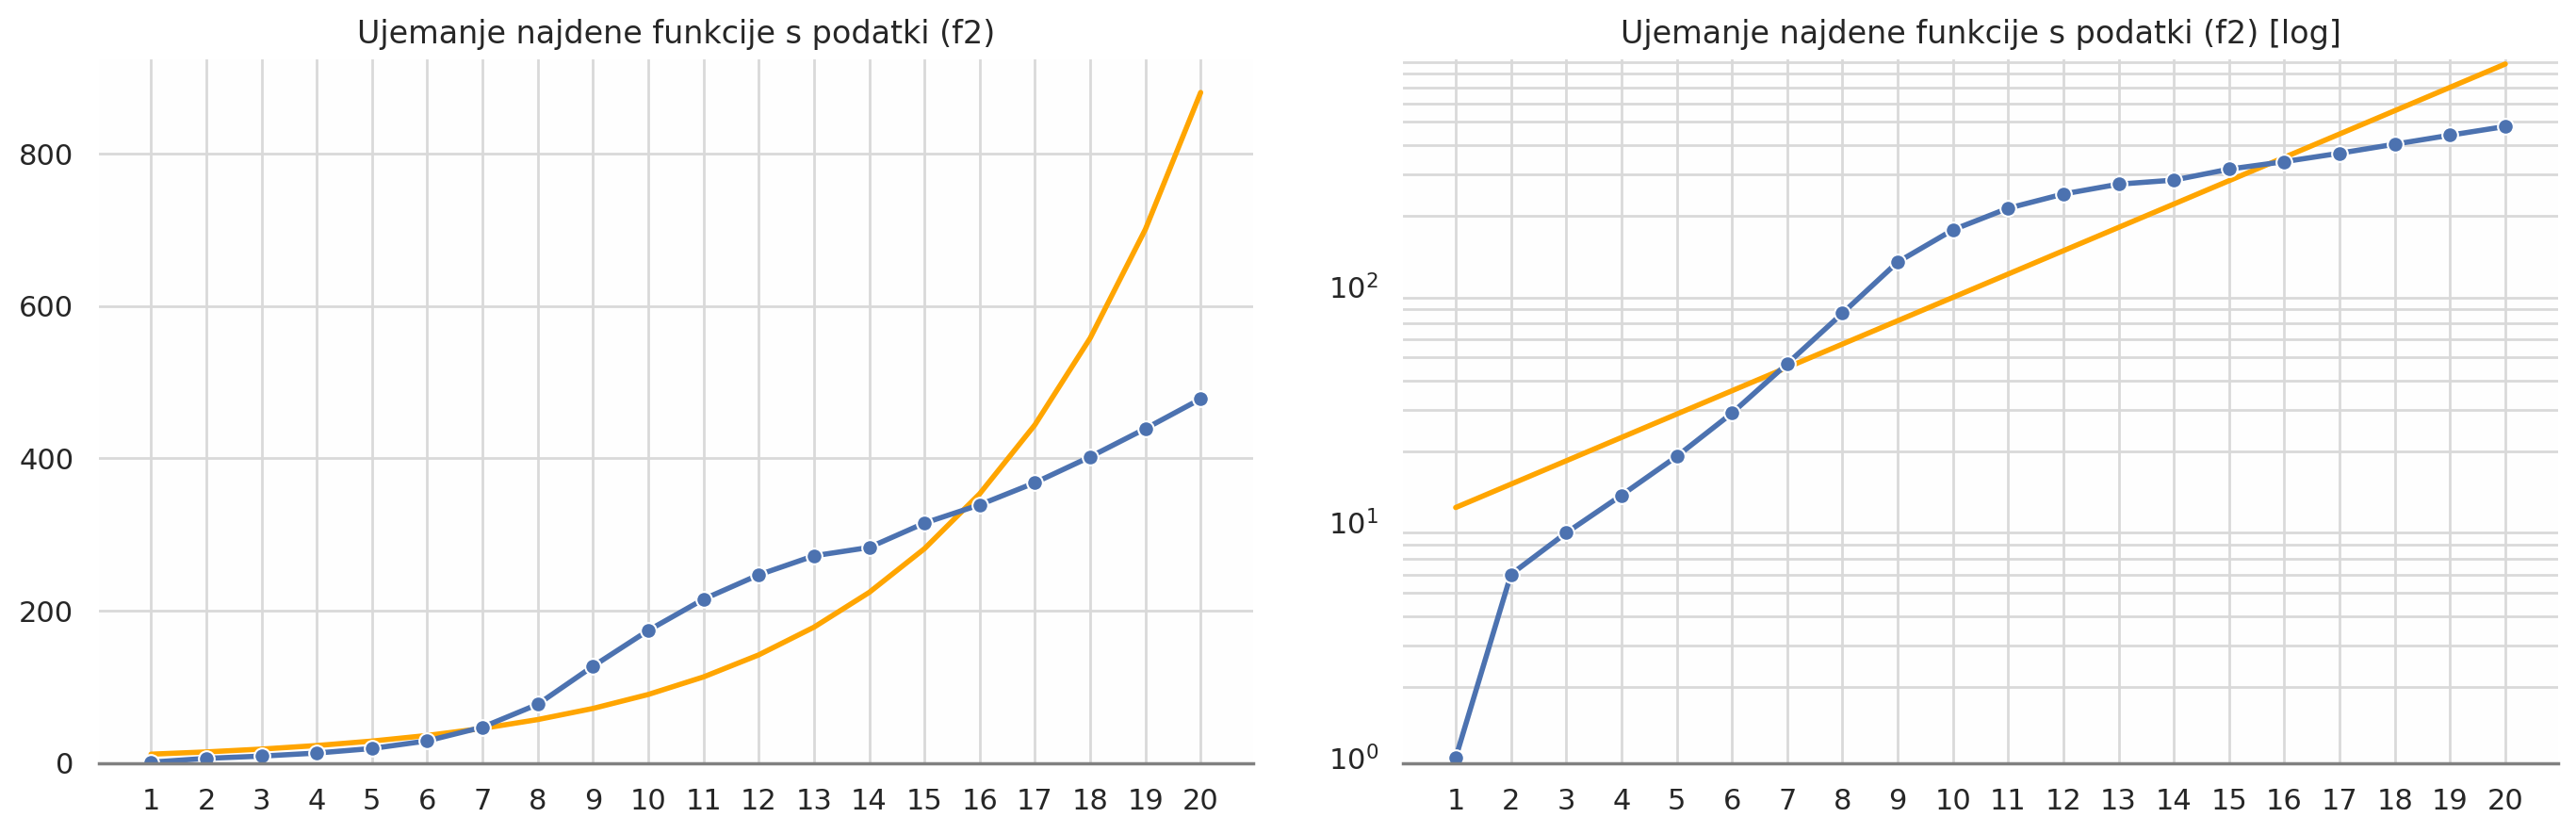

In [44]:
graf("f2", "ujemanje")

**Čas podovijitve** števila okuženih:

In [45]:
print("Št. okuženih se podvoji na %.1f dni." % dbl2)

Št. okuženih se podvoji na 3.0 dni.


## Napoved za naprej

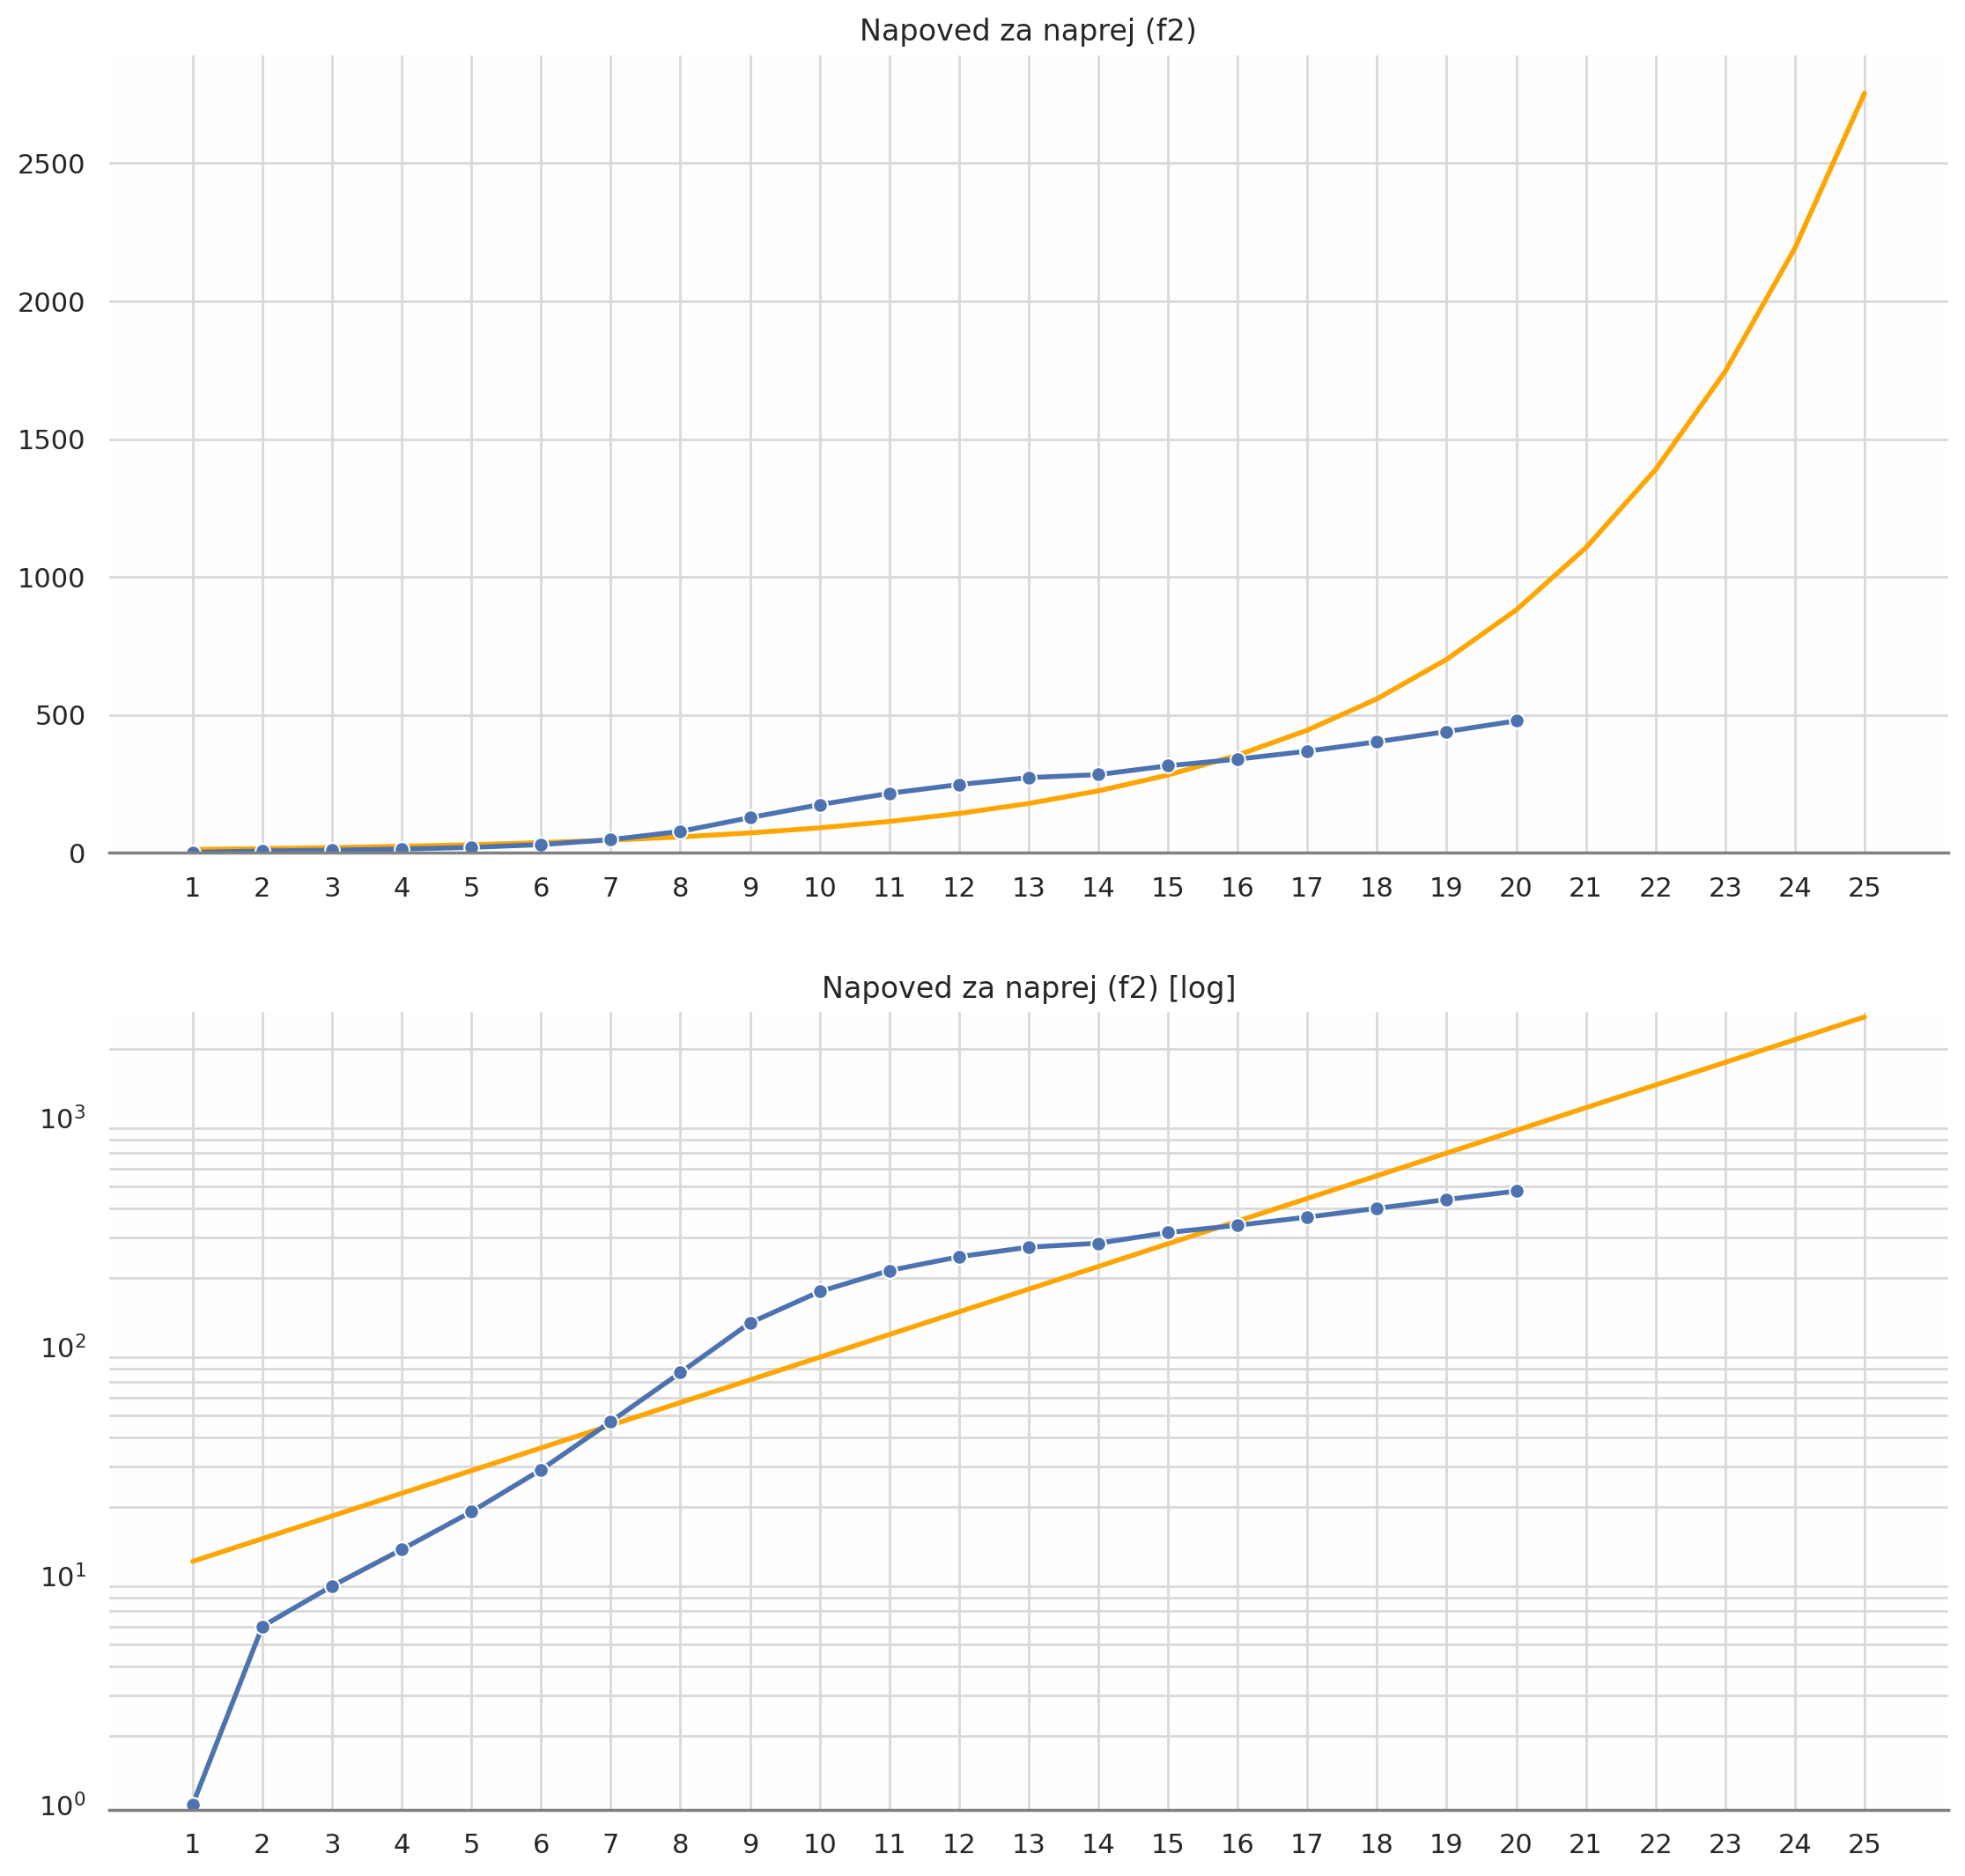

In [46]:
graf("f2", "napoved")

---

%%latex
\newpage

# Iskanje prilegajoče funkcije novih primerov na logaritmiranih podatkih

Najdeni parametri linearne funkcije:

In [47]:
print("k = %.2f\nn = %.2f\n\nf(x) = %.2f * x + %.2f" % (kn, nn, kn, nn))

k = 0.05
n = 0.77

f(x) = 0.05 * x + 0.77


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [48]:
print("a = %.2f\nb = %.2f\n\nf(x) = %.2f ^ (x - (%.2f))" % (a1n, b1n, a1n, b1n))

a = 1.11
b = -5.89

f(x) = 1.11 ^ (x - (-5.89))


## Ujemanje najdene funkcije s podatki

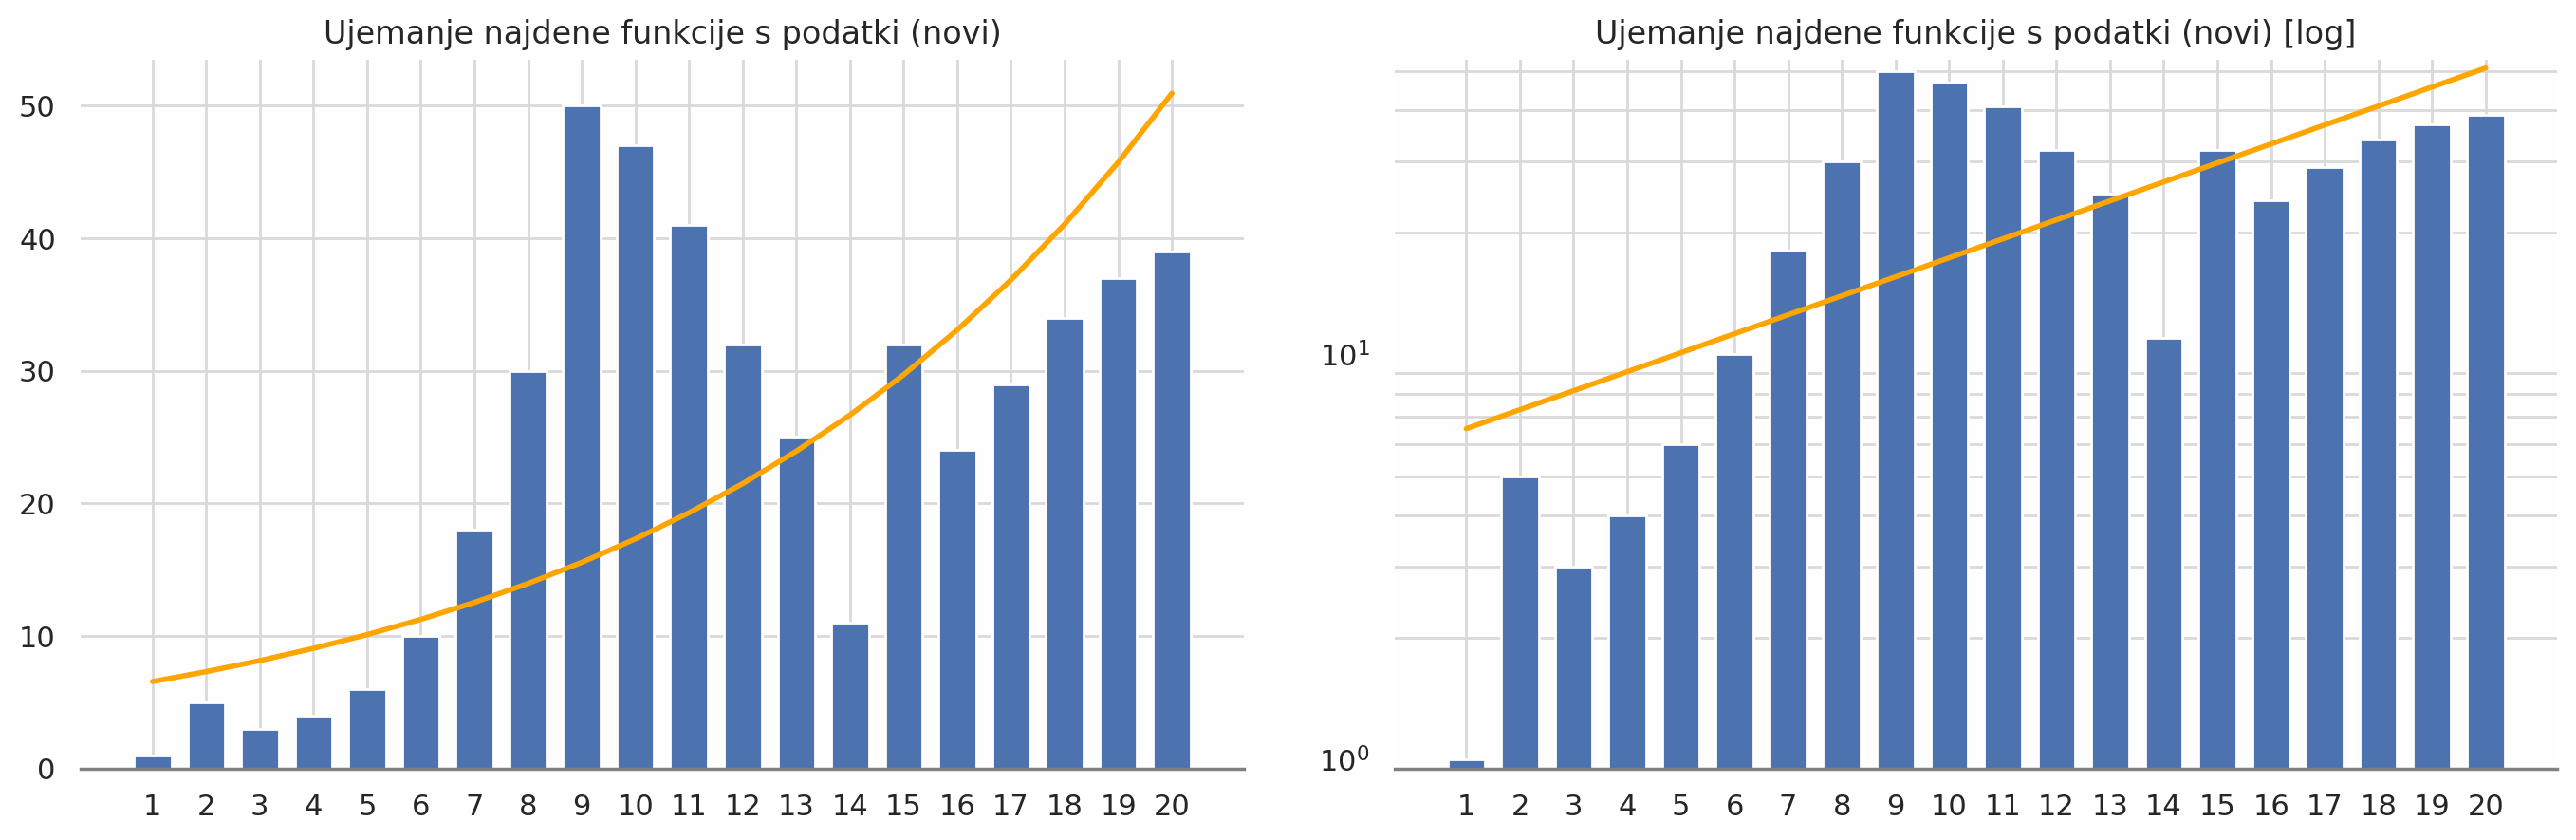

In [49]:
graf("f_novi")

**Čas podovijitve** števila novo okuženih:

In [50]:
print("Št. novo okuženih se podvoji na %.1f dni." % dbl3)

Št. novo okuženih se podvoji na 6.4 dni.


---